
<meta name="viewport" content="width=device-width, initial-scale=1">
<link href="https://cdn.jsdelivr.net/npm/bootstrap@5.3.3/dist/css/bootstrap.min.css" rel="stylesheet">
<link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/6.5.2/css/all.min.css">
<link rel="stylesheet" href="../static/css/styles.css">


        
<!-- <body> -->
<!-- Navigation-->
<nav class="navbar navbar-expand-lg navbar-light fixed-top" id="mainNav">
    <div class="container px-4 px-lg-5">
        <a class="navbar-brand" href="../index.html">Home</a>
        <button class="navbar-toggler" type="button" data-bs-toggle="collapse" data-bs-target="#navbarResponsive" aria-controls="navbarResponsive" aria-expanded="false" aria-label="Toggle navigation">
            Menu
            <i class="fas fa-bars"></i>
        </button>
        <div class="collapse navbar-collapse" id="navbarResponsive">
            <ul class="navbar-nav ms-auto py-4 py-lg-0">
                <li class="nav-item"><a class="nav-link px-lg-3 py-3 py-lg-4" href="../index.html">Executive Summary</a></li>
                <li class="nav-item"><a class="nav-link px-lg-3 py-3 py-lg-4" href="eda.html">Exploratory Data Analysis</a></li>
                <!-- <li class="nav-item"><a class="nav-link px-lg-3 py-3 py-lg-4" href="models.html">Model Construction & Validation</a></li> -->
                <li class="nav-item"><a class="nav-link px-lg-3 py-3 py-lg-4" href="initial_work.html">Reference: Model Development</a></li>
            </ul>
        </div>
    </div>
</nav>



<h2 id="title" style="text-align: center; width: 80%;">Model Construction and Validation</h2>

# Table of Contents

- [Description and Deliverables](#description-and-deliverables)
- [Exploratory Data Analysis Insights](#insights)
- [Modeling Strategies Recap](#modeling-strategies-recap)
  - [Cross-Validation Results](#cross-validation-results)
- [Model Selection](#model-selection)
  - [Logistic Regression Selection](#logistic-regression-selection)
  - [Decision Tree Selection](#decision-tree-selection)
  - [Random Forest Selection](#random-forest-selection)
  - [XGBoost Selection](#xgboost-selection)
- [Model Results](#model-results)
- [Model Interpretation](#model-interpretation)
  - [Logistic Regression Interpretation](#logistic-regression-interpretation)
  - [Decision Tree Interpretation](#decision-tree-interpretation)
  - [Random Forest Interpretation](#random-forest-interpretation)
  - [XGBoost Interpretation](#xgboost-interpretation)
- [Conclusion](#conclusion)
- [Appendix: Data Dictionary](#appendix-data-dictionary)
- [Appendix: Feature Engineering](#appendix-feature-engineering)
- [Appendix: Hyperparameter Tuning Grids](#appendix-hyperparameters)

<div class="button">
    <a href="eda.html">Back to Part 1<br>Exploratory Data Analysis</a>
</div>

<a id="description-and-deliverables"></a>

# **Description and Deliverables**
---

[Back to top](#)

This project builds on insights from exploratory data analysis (EDA) to **develop predictive models for employee attrition** at Salifort Motors. The primary objective was to identify employees at risk of leaving, enabling targeted retention strategies. The modeling process was designed to be rigorous, transparent, and accessible to both technical and non-technical stakeholders.

**Stakeholders:**  
The primary stakeholder is the Human Resources (HR) department, as they will use the results to inform retention strategies. Secondary stakeholders include C-suite executives who oversee company direction, managers implementing day-to-day retention efforts, employees (whose experiences and outcomes are directly affected), and, indirectly, customers—since employee satisfaction can impact customer satisfaction.

**Ethical Considerations:**  
- Ensure employee data privacy and confidentiality throughout the analysis.
- Avoid introducing or perpetuating bias in model predictions (e.g., not unfairly targeting specific groups).
- Maintain transparency in how predictions are generated and how they will be used in HR decision-making.

### This page summarizes the second part of the project: predictive model construction and validation, with interpretation of results.

In [1]:
# Import packages
import time
import joblib
import os

import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import plot_tree

from IPython.display import display, HTML

from sklearn.model_selection import (
    StratifiedKFold,
    cross_val_predict,
    GridSearchCV,
    RandomizedSearchCV,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    fbeta_score,
    precision_recall_curve,
    average_precision_score,
)

In [2]:
# Load dataset into a dataframe
df0 = pd.read_csv("../resources/HR_capstone_dataset.csv")

In [3]:
# Rename columns as needed
df0.rename(
    columns={
        "Department": "department",
        "Work_accident": "work_accident",
        "average_montly_hours": "average_monthly_hours",
        "time_spend_company": "tenure",
    },
    inplace=True,
)

In [4]:
# Drop duplicates and save resulting dataframe in a new variable as needed
df = df0.drop_duplicates()

In [5]:
# Determine the number of rows containing tenure outliers
q1 = df.tenure.quantile(0.25)
q3 = df.tenure.quantile(0.75)
iqr = q3 - q1
upper_bound = q3 + 1.5 * iqr

# # Filter the dataframe to find outliers
# outliers = df[df.tenure > upper_bound]

# # Display the number of outliers
# print(f"Number of tenure outliers: {len(outliers)}")
# print(f"Outliers percentage of total: {len(outliers) / len(df) * 100:.2f}%")

<p class="center-icons">
  <i class="fa fa-circle spacer-icons"></i>
  <i class="fa fa-circle spacer-icons"></i>
  <i class="fa fa-circle spacer-icons"></i>
</p>

<a id="insights"></a>

# **Exploratory Data Analysis Insights**
---

[Back to Top](#)

#### A quick recap of the [exploratory data analysis](./eda.html):

The data suggests significant challenges with employee retention at this company. Two main groups of leavers emerge:

- **Underutilized and Dissatisfied:** Employees in this category worked on fewer projects and logged fewer hours than a typical full-time schedule, and reported lower satisfaction. These individuals may have been disengaged, assigned less work as they prepared to leave, or potentially subject to layoffs or terminations.
- **Overworked and Burned Out:** The second group managed a high number of projects (up to 7) and worked exceptionally long hours—sometimes nearing 80 hours per week. These employees exhibited very low satisfaction and rarely received promotions, suggesting that high demands without recognition or advancement led to burnout and resignation.

A majority of the workforce greatly exceeds the typical 40-hour work week (160–184 hours per month), pointing to a workplace culture that expects long hours. The combination of high workload and limited opportunities for advancement likely fuels dissatisfaction and increases the risk of turnover.

Performance evaluations show only a weak link to attrition; both those who left and those who stayed received similar review scores. This indicates that strong performance alone does not guarantee retention, especially if employees are overworked or lack opportunities for growth.

Other variables—such as department, salary, and work accidents—do not show strong predictive value for employee churn compared to satisfaction and workload. Overall, **the data points to issues with workload management** and limited career progression as the main factors driving employee turnover at this company.

<p class="center-icons">
  <i class="fa fa-circle spacer-icons"></i>
  <i class="fa fa-circle spacer-icons"></i>
  <i class="fa fa-circle spacer-icons"></i>
</p>

<a id="modeling-strategies-recap"></a>

# **Modeling Strategies Recap**
---

[Back to top](#)

*This section summarizes the modeling strategy, key lessons learned, and the criteria used to select the final models.*

#### Approach

Given the business context, the modeling strategy **prioritized recall**—the ability to identify as many at-risk employees as possible—while also considering precision and model simplicity. Four model types were evaluated: Logistic Regression, Decision Tree, Random Forest, and XGBoost. Each model was developed using a systematic pipeline approach to ensure reproducibility and prevent data leakage.

Key steps included:
- **Data Preparation**: Outliers were removed for logistic regression, and all preprocessing was handled within scikit-learn `Pipelines`.
- **Cross-Validation**: Stratified K-Fold cross-validation was used throughout to ensure robust performance estimates, especially given class imbalance.
- **Hyperparameter Tuning**: `GridSearchCV` was used for simpler models, while `RandomizedSearchCV` was adopted for more complex models to balance thoroughness and computational efficiency. Details [here](#appendix-hyperparameters).
- **Feature Engineering**: Multiple rounds of feature engineering and selection were conducted, focusing on satisfaction, workload, tenure, and interaction terms identified as important in EDA. Details [here](#appendix-feature-engineering).
- **Model Evaluation**: In addition to standard metrics (recall, precision, F₁, ROC AUC), a custom F₂ score was introduced to explicitly weight recall four times higher than precision, reflecting the business priority of minimizing false negatives.

#### Lessons Learned

The modeling process was iterative and exploratory, reflecting both best practices and lessons learned:
- **Metric Selection Matters**: Initial experiments optimizing for AUC led to suboptimal recall, especially for logistic regression. Refocusing on recall as the primary metric improved model alignment with business goals.
- **Model Complexity vs. Interpretability**: Tree-based models (Random Forest, XGBoost) consistently outperformed logistic regression in overall metrics, but targeted feature engineering allowed logistic regression to become competitive while remaining highly interpretable.
- **Feature Engineering**: Additional features and interaction terms provided modest improvements, but the most significant gains came from careful feature selection and focusing on core predictors.
- **Efficiency and Automation**: Automating pipeline construction and model evaluation streamlined experimentation and reduced the risk of errors or data leakage.


#### Final Model Selection

With several high-performing models, explicit selection criteria were established:

1. Minimum recall threshold (≥ 0.935)
2. Minimum F₂ score (≥ 0.85)
3. Fewest features (for simplicity and interpretability)
4. Highest F₂ score
5. Highest precision

This approach ensured that the final models were not only accurate but also practical for deployment and stakeholder communication.

#### Next Steps

The selected models will be retrained on the full training set and evaluated on the holdout test set (`X_test`). Results—including confusion matrices, feature importances, and actionable insights—will be communicated to HR and leadership to inform retention strategies. The process and findings will be documented to support transparency, ethical use, and ongoing model improvement.

---

<a id="cross-validation-results)"></a>

## &#8227; Cross-Validation Results


[Back to top](#)

This section presents the cross-validated results of all modeling strategies to date. Here, we summarize model performance prior to retraining the final selected models on the full training set and evaluating them on the holdout test set (`X_test`). The results include a comprehensive table of evaluation metrics for each model, as well as visualizations of confusion matrices for both the baseline and top-performing models. These outputs provide a clear comparison of model effectiveness and support transparent, data-driven model selection.

In [6]:
# show confusion matrix exemplar
# display(Image(filename="../resources/images/confusion_matrix_exemplar.png", width=800))
display(
    HTML(
        """
<img src="../resources/images/confusion_matrix_exemplar.png" style="max-width:100%; height:auto; display:block; margin:auto;">
"""
    )
)

In [7]:
# display confusion matrix for base model
# display(Image(filename="../results/images/base_model_confusion_matrices_confusion_grid.png", width=800))
display(
    HTML(
        """
<img src="../results/images/base_model_confusion_matrices_confusion_grid.png" style="max-width:100%; height:auto; display:block; margin:auto;">
"""
    )
)

In [8]:
# display all model evaluation results
df_results = pd.read_csv("../results/all_model_evaluation_results.csv")
df_results = df_results.rename(
    columns={
        "model": "Model",
        "recall": "Recall",
        "f2": "F2 Score",
        "f1": "F1 Score",
        "roc_auc": "ROC AUC",
        "precision": "Precision",
        "accuracy": "Accuracy",
        "features": "Num Features",
        "best_params": "Best Params",
        "cv_best_score": "CV Best Score",
        "conf_matrix": "Confusion Matrix",
        "search_time": "Search Time (s)",
    }
)
df_results[
    [
        "Model",
        "Recall",
        "F2 Score",
        "F1 Score",
        "Precision",
        "Accuracy",
        "ROC AUC",
        "Num Features",
        "Confusion Matrix",
        "Search Time (s)",
    ]
]

,Model,Recall,F2 Score,F1 Score,Precision,Accuracy,ROC AUC,Num Features,Confusion Matrix,Search Time (s)
0,Logistic Regression (Core + Interactions),0.962126,0.817433,0.666974,0.510398,0.838128,0.888335,6,"[[6039, 1389], [57, 1448]]",0.801151
1,Logistic Regression with Interaction (feature ...,0.960133,0.819161,0.671312,0.516071,0.841599,0.891666,10,"[[6073, 1355], [60, 1445]]",2.056098
2,Logistic Regression (Core + Interactions + Bur...,0.951495,0.825836,0.689290,0.540377,0.855480,0.903177,6,"[[6210, 1218], [73, 1432]]",0.982459
3,Logistic Regression (base),0.947508,0.796203,0.642342,0.485860,0.822232,0.891388,18,"[[5919, 1509], [79, 1426]]",5.170930
4,Decision Tree (Core + Burnout),0.943503,0.887040,0.813972,0.715714,0.928378,0.956257,7,"[[7402, 597], [90, 1503]]",2.831705
5,Decision Tree (base),0.942247,0.881179,0.803103,0.699767,0.923269,0.945551,18,"[[7355, 644], [92, 1501]]",2.358475
6,Random Forest (Core + Burnout),0.940992,0.896317,0.836729,0.753266,0.939012,0.976981,7,"[[7508, 491], [94, 1499]]",78.417716
7,Random Forest (base),0.940364,0.863799,0.769784,0.651588,0.906589,0.964169,18,"[[7198, 801], [95, 1498]]",178.203500
8,Logistic Regression with Binning (feature sele...,0.939535,0.855104,0.753531,0.629004,0.896451,0.947481,14,"[[6594, 834], [91, 1414]]",1.312480
9,Logistic Regression with Binning,0.937542,0.854944,0.755151,0.632168,0.897571,0.952159,26,"[[6607, 821], [94, 1411]]",3.109411


In [9]:
# display confusion matrix for all models, top 9
# display(Image(filename="../results/images/top_model_confusion_matrices_confusion_grid.png", width=800))
display(
    HTML(
        """
<img src="../results/images/top_model_confusion_matrices_confusion_grid.png" style="max-width:100%; height:auto; display:block; margin:auto;">
"""
    )
)

<p class="center-icons">
  <i class="fa fa-circle spacer-icons"></i>
  <i class="fa fa-circle spacer-icons"></i>
  <i class="fa fa-circle spacer-icons"></i>
</p>

<a id="model-selection"></a>

# **Model Selection**
---

[Back to top](#)

*This section details the selection process, data dictionary, and best hyperparameters for each final model.*

#### **Choose evaluation metric**

While **ROC AUC** is a common metric for evaluating binary classifiers—offering a threshold-independent measure of how well the model distinguishes between classes—it is **not ideal for imbalanced problems like employee churn**, where the positive class (those likely to leave) is much smaller and more critical to identify.

During model development, I did review ROC AUC to get a general sense of model discrimination. However, for **model selection and tuning**, I ultimately prioritized **recall**. A high recall ensures that we identify as many at-risk employees as possible, aligning with the company's goal to support retention through early intervention. Missing a potential churner (a false negative) is generally more costly than mistakenly flagging someone who is not at risk (a false positive), especially when interventions are supportive rather than punitive.

While precision is also important—since too many false positives could dilute resources or create unnecessary concern—recall is more aligned with a **proactive retention strategy**. This tradeoff assumes that HR interventions are constructive and that the company has systems in place to act ethically on model outputs.

To avoid unintended harm, I recommend implementing **clear usage guidelines** and **transparency** measures, ensuring that predictions are used to help employees, not penalize them. Calibration and regular fairness audits should accompany any deployment of the model.

#### **Evaluation Tie Breaker**

 One final twist (I hope). I made the classic mistake of not clearly and rigidly defining success, and I now have a bunch of models that are all excellent at recall, hovering in the 0.93-0.96 range. So I'm making a post-hoc call. At least this one, I'm planning ahead of time. The best model (of each type) will be chosen based on the following tie-breakers (in order):
- recall > 0.935
- f2 > 0.85 (f2 is a new score, weighing recall at 80%, and precision at 20%)
- fewest number of features
- highest f2
- highest precision

I should hope i can make a choice by then. there can't be that many models. I... hehehe... predict... that I'll have it by number three, fewest number of features

In [10]:
"""Set evaluation metric"""

scoring = "recall"


# for XGBoost eval_metric
def get_xgb_eval_metric(scoring):
    mapping = {
        "roc_auc": "auc",  # area under ROC curve
        "accuracy": "error",  # classification error rate
        "f1": "logloss",  # logarithmic loss (not F1, but closest available)
        "precision": "logloss",  # no direct precision metric, logloss is a common fallback
        "recall": "logloss",  # no direct recall metric, logloss is a common fallback
    }
    return mapping.get(scoring, "auc")  # default to 'auc' if not found

In [11]:
"""Encode categorical variables."""

# copy the dataframe to avoid modifying the original
df_enc = df.copy()

# encode salary as ordinal
df_enc["salary"] = df_enc["salary"].map({"low": 0, "medium": 1, "high": 2})

# encode department as dummies
df_enc = pd.get_dummies(df_enc, columns=["department"])

In [12]:
"""
Split the data into train / test sets for different models

One set for tree-based models (decision tree, random forest, XGBoost)
Another set for logistic regression (which must have outliers removed and data normalized)
Stratify the target variable each time to account for class imbalance.
"""


# split the data into features and target variable for tree-based models
X = df_enc.drop(columns=["left"])
y = df_enc["left"]

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# scale_pos_weight for XGBoost (ratio of negative to positive class in training set)
# handles class imbalance
scale_pos_weight_value = (y_train == 0).sum() / (y_train == 1).sum()

In [13]:
# split the data into features and target variable for logistic regression
# remove outliers from tenure for logistic regression
df_enc_lr = df_enc.copy()

"""
outliers defined waaaaaay up above, 
at end of inital data exploration and cleaning
code not needed here, but copied for reference
"""
# q1 = df.tenure.quantile(0.25)
# q3 = df.tenure.quantile(0.75)
# iqr = q3 - q1
# upper_bound = q3 + 1.5 * iqr

# remove outliers
df_enc_lr = df_enc_lr[df_enc_lr.tenure < upper_bound]

X_lr = df_enc_lr.drop(columns=["left"])
y_lr = df_enc_lr["left"]

# split the data into training and testing sets for logistic regression
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(
    X_lr, y_lr, test_size=0.2, random_state=42, stratify=y_lr
)

In [14]:
"""
Supporting functions for model evaluation and feature engineering.

Functions to assemble model configurations,
run those models through cross-validation and hyperparameter tuning for evaluation,
and do feature engineering.
"""


# build models_config for run_model_evaluation
def make_models_config(
    models,
    X_train,
    y_train,
    feature_func=None,  # can be a function, list, dict, or None
    param_grids=None,
    scaler=None,
    name_suffix="",
):
    """
    Build models_config for run_model_evaluation.
    - models: dict of {name: estimator}
    - X_train, y_train: training data
    - feature_func: function, list of functions, dict of {name: func}, or None
    - param_grids: dict of {name: param_grid} (or None for empty)
    - scaler: sklearn transformer (e.g., StandardScaler) or None
    - name_suffix: string to append to model name
    """
    configs = []
    for name, model in models.items():
        # order of steps matters, features first, then scaler, then model
        steps = []

        # determine which feature_func to use for this model
        func = None
        if isinstance(feature_func, dict):  # dict of {name: func}
            func = feature_func.get(name)
        elif callable(feature_func) or isinstance(feature_func, list):
            func = feature_func
        # handles a list of feature functions (apply in sequence), or a single function
        if func is not None:
            if isinstance(func, list):
                for i, f in enumerate(func):
                    steps.append((f"features_{i+1}", FunctionTransformer(f)))
            else:
                steps.append(("features", FunctionTransformer(func)))

        # add scaler if provided
        if scaler is not None:
            steps.append(("scaler", scaler))

        # add model
        steps.append(("model", model))

        # create the pipeline
        pipe = Pipeline(steps)

        # add parameter grid if provided
        param_grid = {}
        if isinstance(param_grids, dict):
            param_grid = param_grids.get(name, {})

        # add model configuration to the list
        configs.append(
            {
                "name": f"{name}{name_suffix}",
                "X_train": X_train,
                "y_train": y_train,
                "pipeline": pipe,
                "param_grid": param_grid,
            }
        )
    return configs

In [15]:
# run model evaluation function
def run_model_evaluation(
    models_config,
    results_df=None,
    scoring="recall",
    save_model=False,
    search_type="grid",
    n_iter=20,
):
    """
    Run model training and evaluation for a list of model configurations using cross-validated hyperparameter search.

    For each model configuration, performs hyperparameter tuning (GridSearchCV or RandomizedSearchCV),
    fits the best pipeline, evaluates cross-validated performance metrics, and optionally saves the best model.

    Parameters:
        models_config (list of dict): List of model configurations, each containing:
            - 'name': Model name (str)
            - 'X_train': Training features (pd.DataFrame or np.ndarray)
            - 'y_train': Training labels (pd.Series or np.ndarray)
            - 'pipeline': sklearn Pipeline object
            - 'param_grid': dict of hyperparameters for search
        results_df (pd.DataFrame or None): Existing results DataFrame to append to, or None to create a new one.
        scoring (str): Scoring metric for model selection (e.g., 'recall', 'accuracy', 'roc_auc').
        save_model (bool): If True, saves the best model pipeline to disk for each configuration.
        search_type (str): 'grid' for GridSearchCV, 'random' for RandomizedSearchCV.
        n_iter (int): Number of parameter settings sampled for RandomizedSearchCV (ignored for grid search).

    Returns:
        pd.DataFrame: Results DataFrame with model name, metrics (recall, f1, roc_auc, precision, accuracy),
                      number of features, best hyperparameters, best CV score, confusion matrix, and search time.

    Notes:
        - Uses stratified 5-fold cross-validation for both hyperparameter search and out-of-fold predictions.
        - Calculates metrics on cross-validated predictions for robust performance estimates.
        - Handles models that do not support predict_proba for ROC AUC gracefully.
        - Saves models to '../results/saved_models/' if save_model=True.
    """
    if results_df is None:
        results_df = pd.DataFrame(
            columns=[
                "Model",
                "Recall",
                "F2",  # 80% recall, 20% precision (metric created to weigh recall more heavily)
                "F1",  # 50% recall, 50% precision
                "ROC AUC",
                "Precision",
                "Accuracy",
                "Features",
                "Best Params",
                "CV Best Score",
                "Confusion Matrix",
                "Search Time (s)",
            ]
        )

    # ensure cross-validation is stratified for balanced class distribution
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for cfg in models_config:
        # time the model training and evaluation
        start_time = time.time()
        # print(f"Running model: {cfg['name']}...")

        # conditional to choose search type, instantiate the appropriate search class
        if search_type == "random":
            grid = RandomizedSearchCV(
                cfg["pipeline"],
                cfg["param_grid"],
                n_iter=n_iter,
                cv=cv,
                scoring=scoring,
                n_jobs=-1,
                # verbose=2,
                random_state=42,
            )
        else:
            grid = GridSearchCV(
                cfg["pipeline"],
                cfg["param_grid"],
                cv=cv,
                scoring=scoring,
                n_jobs=-1,
                # verbose=2,
            )

        # fit the grid search to the training data
        grid.fit(cfg["X_train"], cfg["y_train"])

        # print the execution time
        end_time = time.time()
        search_time = end_time - start_time
        # print(f"Execution time for {cfg['name']}: {search_time:.2f} seconds")

        # get the best model and its parameters
        best_model = grid.best_estimator_
        # print(f"Best parameters for {cfg['name']}: {grid.best_params_}")
        # print(f"Best score for {cfg['name']}: {grid.best_score_:.4f} ({scoring})")

        # --- get the number of features after all pipeline steps ---
        # try to transform X_train through all steps except the final estimator
        try:
            if hasattr(best_model, "named_steps"):
                # Remove the final estimator step
                steps = list(best_model.named_steps.items())
                if len(steps) > 1:
                    # Remove last step (the model)
                    feature_pipeline = Pipeline(steps[:-1])
                    X_transformed = feature_pipeline.transform(cfg["X_train"])
                    n_features = X_transformed.shape[1]
                else:
                    n_features = cfg["X_train"].shape[1]
            else:
                n_features = cfg["X_train"].shape[1]
        except Exception as e:
            print(f"Could not determine number of features: {e}")
            n_features = cfg["X_train"].shape[1]

        # conditional to save the best model
        if save_model:
            model_path = f"../results/saved_models/{cfg['name'].replace(' ', '_').lower()}.joblib"
            joblib.dump(best_model, model_path)
            # print(f"Model {cfg['name']} saved successfully.\n")
        else:
            print(f"Model {cfg['name']} not saved. Set save_model=True to save it.\n")

        # make predictions using cross-validation to generate out-of-fold predictions for each training sample
        # translation:
        # substitute for setting aside a validation set
        # takes more time, but provides better estimates of model performance
        # it makes a prediction for each sample in the training set, using a different fold of the data for each prediction...
        # ...the fold where the sample is not included in the 80% training set (the sample is in the 20%)
        y_pred = cross_val_predict(
            best_model, cfg["X_train"], cfg["y_train"], cv=cv, n_jobs=-1
        )

        # calculate the ROC AUC score, need predicted probabilities (not just class labels, but confidence in those labels)
        # try / except block to handle models that do not support predict_proba (e.g., SVC)
        try:
            y_proba = cross_val_predict(
                best_model,
                cfg["X_train"],
                cfg["y_train"],
                cv=cv,
                method="predict_proba",
                n_jobs=-1,
            )
            roc_auc = roc_auc_score(cfg["y_train"], y_proba[:, 1])
        except (AttributeError, ValueError):
            roc_auc = np.nan
            print(f"Model {cfg['name']} does not support predict_proba.")

        # save results in the results dataframe
        results_df.loc[len(results_df)] = {
            "Model": cfg["name"],
            "Features": n_features,
            "Accuracy": accuracy_score(cfg["y_train"], y_pred),
            "Precision": precision_score(cfg["y_train"], y_pred),
            "Recall": recall_score(cfg["y_train"], y_pred),
            "F1": f1_score(cfg["y_train"], y_pred),
            "F2": fbeta_score(
                cfg["y_train"], y_pred, beta=2
            ),  # 80% recall, 20% precision (ratio is "beta squared : 1", b^2:1, 2^2:1, 4:1)
            "ROC AUC": roc_auc,
            "Confusion Matrix": confusion_matrix(cfg["y_train"], y_pred).tolist(),
            "Best Params": grid.best_params_,
            "CV Best Score": grid.best_score_,
            "Search Time (s)": search_time,
        }

    return results_df

In [16]:
"""
feature engineering / feature selection functions
the functions commented out below are not used in the final notebook,
but were used during model development
and are included for reference
"""


# NOTE used in Logistic Regression's winner - "with Binning (feature selection)"
# add binning features
def add_binning_features(df):
    df = df.copy()
    df["satisfaction_bin"] = pd.cut(
        df["satisfaction_level"],
        bins=[-0.01, 0.4, 0.7, 1.0],
        labels=["low", "medium", "high"],
    )
    df["hours_bin"] = pd.cut(
        df["average_monthly_hours"],
        bins=[0, 160, 240, np.inf],
        labels=["low", "medium", "high"],
    )
    df["projects_bin"] = pd.cut(
        df["number_project"], bins=[0, 2, 5, np.inf], labels=["low", "medium", "high"]
    )
    df["tenure_bin"] = pd.cut(
        df["tenure"], bins=[0, 3, 5, np.inf], labels=["short", "mid", "long"]
    )
    # encode the binned features as dummies
    df = pd.get_dummies(
        df,
        columns=["satisfaction_bin", "hours_bin", "projects_bin", "tenure_bin"],
        drop_first=True,
    )
    return df


# # add interaction features
# def add_interaction_features(df):
#     df = df.copy()
#     df["satisfaction_x_projects"] = df["satisfaction_level"] * df["number_project"]
#     df["satisfaction_x_hours"] = df["satisfaction_level"] * df["average_monthly_hours"]
#     df["evaluation_x_satisfaction"] = df["last_evaluation"] * df["satisfaction_level"]
#     df["hours_per_project"] = df["average_monthly_hours"] / df["number_project"]
#     return df


# # add flag features
# def add_flag_features(df):
#     df = df.copy()
#     df["burnout"] = (
#         (df["number_project"] >= 6) | (df["average_monthly_hours"] >= 240)
#     ) & (df["satisfaction_level"] <= 0.3)
#     df["disengaged"] = (
#         (df["number_project"] <= 2)
#         & (df["average_monthly_hours"] < 160)
#         & (df["satisfaction_level"] <= 0.5)
#     )
#     df["no_promo_4yr"] = (df["promotion_last_5years"] == 0) & (df["tenure"] >= 4)
#     return df

# NOTE used in Logistic Regression's winner - "with Binning (feature selection)"
# feature selection for logistic regression
drop_cols = [col for col in X_train_lr.columns if col.startswith("department_")]
drop_cols += ["salary", "work_accident"]
X_train_lr_fs = X_train_lr.drop(columns=drop_cols)

# # feature selection for tree-based models
# drop_cols = [col for col in X_train.columns if col.startswith("department_")]
# drop_cols += ["salary", "work_accident"]
# X_train_fs = X_train.drop(columns=drop_cols)

In [17]:
# NOTE This is the group of features that 'won' for all tree-based models
# selected features + burnout flag
def select_core_features_with_burnout(df):
    df = df.copy()
    # burnout flag: (projects >= 6 or hours >= 240) & satisfaction <= 0.3
    df["burnout"] = (
        (df["number_project"] >= 6) | (df["average_monthly_hours"] >= 240)
    ) & (df["satisfaction_level"] <= 0.3)
    return df[
        [
            "satisfaction_level",
            "last_evaluation",
            "number_project",
            "average_monthly_hours",
            "tenure",
            "promotion_last_5years",
            "burnout",
        ]
    ]


# # selected features + interactions
# def select_core_features_with_interactions(df):
#     df = df.copy()
#     # interactions
#     df["satisfaction_x_projects"] = df["satisfaction_level"] * df["number_project"]
#     df["hours_per_project"] = df["average_monthly_hours"] / df["number_project"]
#     return df[
#         [
#             "satisfaction_level",
#             "number_project",
#             "average_monthly_hours",
#             "tenure",
#             "satisfaction_x_projects",
#             "hours_per_project",
#         ]
#     ]


# # selected features + interactions + burnout flag
# def select_core_features_with_interactions_and_burnout(df):
#     df = df.copy()
#     # burnout flag: (projects >= 6 or hours >= 240) & satisfaction <= 0.3
#     df["burnout"] = (
#         (df["number_project"] >= 6) | (df["average_monthly_hours"] >= 240)
#     ) & (df["satisfaction_level"] <= 0.3)
#     # interaction
#     df["satisfaction_x_projects"] = df["satisfaction_level"] * df["number_project"]
#     return df[
#         [
#             "satisfaction_level",
#             "number_project",
#             "average_monthly_hours",
#             "tenure",
#             "burnout",
#             "satisfaction_x_projects",
#         ]
#     ]

<p class="center-icons">
  <i class="fa fa-circle spacer-icons"></i>
  <i class="fa fa-circle spacer-icons"></i>
  <i class="fa fa-circle spacer-icons"></i>
</p>

<a id="logistic-regression-selection"></a>

## &#8227; Logistic Regression Selection

[Back to top](#)

In [18]:
# logistic regression feature engineering hyperparameters
lr_fe_params = {
    "model__C": [0.1, 1.0, 10.0],  # regularization strength (inverse)
    "model__penalty": ["l1", "l2"],  # regularization type (L1 = Lasso, L2 = Ridge)
    "model__solver": ["liblinear"],  # optimization algorithm (liblinear supports L1/L2)
    "model__class_weight": [None, "balanced"],  # None or balanced for class imbalance
}

# define feature engineered logistic regression models, their feature functions, and parameter grids
lr_fe_models = {
    "Logistic Regression with Binning": LogisticRegression(
        max_iter=1000, random_state=42
    ),
}
lr_fe_feature_funcs = {
    "Logistic Regression with Binning": add_binning_features,
}
lr_fe_param_grids = {
    "Logistic Regression with Binning": lr_fe_params,
}

# create models_config for logistic regression with feature engineering and feature selection
lr_fe_fs_configs = make_models_config(
    lr_fe_models,
    X_train_lr_fs,
    y_train_lr,
    feature_func=lr_fe_feature_funcs,
    scaler=StandardScaler(),
    param_grids=lr_fe_param_grids,
    name_suffix=" (feature selection)",
)

<div class="emphasis-box">
  <strong>Model selection criteria aligned with both business and performance goals (in order):</strong>
  <ul>
    <li>A <strong>minimum recall threshold</strong> of 0.935</li>
    <li>A <strong>minimum F<sub>2</sub> score</strong> of 0.85 (prioritizing recall at a 4:1 weight over precision)</li>
    <li>Preference for models with <strong>fewer features</strong></li>
    <li>Tie-breaking by <strong>highest F<sub>2</sub></strong>, followed by <strong>precision</strong></li>
  </ul>
</div>

All Logistic Regression Models:

In [19]:
# display model evaluation results for all logistic regression models
df_lr = df_results[df_results["Model"].str.contains("Logistic Regression")]
if df_lr.empty:
    print("No logistic regression models found in results.")

# print("Logistic Regression Model Evaluation Results:")
df_lr = df_lr[
    [
        "Model",
        "Recall",
        "F2 Score",
        "F1 Score",
        "Precision",
        "Accuracy",
        "ROC AUC",
        "Num Features",
        "Confusion Matrix",
    ]
]
df_lr

,Model,Recall,F2 Score,F1 Score,Precision,Accuracy,ROC AUC,Num Features,Confusion Matrix
0,Logistic Regression (Core + Interactions),0.962126,0.817433,0.666974,0.510398,0.838128,0.888335,6,"[[6039, 1389], [57, 1448]]"
1,Logistic Regression with Interaction (feature ...,0.960133,0.819161,0.671312,0.516071,0.841599,0.891666,10,"[[6073, 1355], [60, 1445]]"
2,Logistic Regression (Core + Interactions + Bur...,0.951495,0.825836,0.689290,0.540377,0.855480,0.903177,6,"[[6210, 1218], [73, 1432]]"
3,Logistic Regression (base),0.947508,0.796203,0.642342,0.485860,0.822232,0.891388,18,"[[5919, 1509], [79, 1426]]"
8,Logistic Regression with Binning (feature sele...,0.939535,0.855104,0.753531,0.629004,0.896451,0.947481,14,"[[6594, 834], [91, 1414]]"
9,Logistic Regression with Binning,0.937542,0.854944,0.755151,0.632168,0.897571,0.952159,26,"[[6607, 821], [94, 1411]]"
16,Logistic Regression (Core + Burnout),0.934884,0.798796,0.655638,0.504844,0.834546,0.886564,7,"[[6048, 1380], [98, 1407]]"
20,Logistic Regression with Interaction,0.933555,0.808121,0.672571,0.525627,0.846860,0.901327,22,"[[6160, 1268], [100, 1405]]"
38,Logistic Regression with Flags (feature select...,0.917608,0.870524,0.808311,0.722280,0.926676,0.953360,9,"[[6897, 531], [124, 1381]]"
39,Logistic Regression with Flags,0.917608,0.868335,0.803608,0.714803,0.924437,0.957952,21,"[[6877, 551], [124, 1381]]"


Above the minimum recall threshold of 0.935:

In [20]:
df_lr_1 = df_lr[df_lr["Recall"] >= 0.935]
df_lr_1

,Model,Recall,F2 Score,F1 Score,Precision,Accuracy,ROC AUC,Num Features,Confusion Matrix
0,Logistic Regression (Core + Interactions),0.962126,0.817433,0.666974,0.510398,0.838128,0.888335,6,"[[6039, 1389], [57, 1448]]"
1,Logistic Regression with Interaction (feature ...,0.960133,0.819161,0.671312,0.516071,0.841599,0.891666,10,"[[6073, 1355], [60, 1445]]"
2,Logistic Regression (Core + Interactions + Bur...,0.951495,0.825836,0.689290,0.540377,0.855480,0.903177,6,"[[6210, 1218], [73, 1432]]"
3,Logistic Regression (base),0.947508,0.796203,0.642342,0.485860,0.822232,0.891388,18,"[[5919, 1509], [79, 1426]]"
8,Logistic Regression with Binning (feature sele...,0.939535,0.855104,0.753531,0.629004,0.896451,0.947481,14,"[[6594, 834], [91, 1414]]"
9,Logistic Regression with Binning,0.937542,0.854944,0.755151,0.632168,0.897571,0.952159,26,"[[6607, 821], [94, 1411]]"


Above the minimum F₂ threshold of 0.85:

In [21]:
df_lr_2 = df_lr_1[df_lr_1["F2 Score"] >= 0.85]
df_lr_2

,Model,Recall,F2 Score,F1 Score,Precision,Accuracy,ROC AUC,Num Features,Confusion Matrix
8,Logistic Regression with Binning (feature sele...,0.939535,0.855104,0.753531,0.629004,0.896451,0.947481,14,"[[6594, 834], [91, 1414]]"
9,Logistic Regression with Binning,0.937542,0.854944,0.755151,0.632168,0.897571,0.952159,26,"[[6607, 821], [94, 1411]]"


With the fewest features:

In [22]:
df_lr_winner = df_lr_2[df_lr_2["Num Features"] == df_lr_2["Num Features"].min()]
df_lr_winner

,Model,Recall,F2 Score,F1 Score,Precision,Accuracy,ROC AUC,Num Features,Confusion Matrix
8,Logistic Regression with Binning (feature sele...,0.939535,0.855104,0.753531,0.629004,0.896451,0.947481,14,"[[6594, 834], [91, 1414]]"


And the winner is "Logistic Regression with Binning (feature selection)"

In [23]:
""" 
Model, feature function, and parameter grid definitions
 (used to build pipelines) 
 located at beginning of Logistic Regression section 
 """
results_training = run_model_evaluation(
    lr_fe_fs_configs, scoring=scoring, save_model=True
)

#### Data Dictionary: 

**Logistic Regression with Binning (Feature Selection)**

This model uses a subset of the original features, applies binning to key variables, and drops department, salary, and work_accident.

| Variable                       | Description                                                                                 |
|---------------------------------|---------------------------------------------------------------------------------------------|
| satisfaction_level              | Employee-reported job satisfaction level [0–1]                                              |
| last_evaluation                 | Score of employee's last performance review [0–1]                                           |
| number_project                  | Number of projects employee contributes to                                                  |
| average_monthly_hours           | Average number of hours employee worked per month                                           |
| tenure                          | How long the employee has been with the company (years)                                     |
| promotion_last_5years           | Whether or not the employee was promoted in the last 5 years                                |
| satisfaction_bin_medium         | Binary indicator: satisfaction_level is medium (> 0.4 and ≤ 0.7)                            |
| satisfaction_bin_high           | Binary indicator: satisfaction_level is high (> 0.7)                                       |
| hours_bin_medium                | Binary indicator: average_monthly_hours is medium (> 160 and ≤ 240)                         |
| hours_bin_high                  | Binary indicator: average_monthly_hours is high (> 240)                                    |
| projects_bin_medium             | Binary indicator: number_project is medium (> 2 and ≤ 5)                                    |
| projects_bin_high               | Binary indicator: number_project is high (> 5)                                             |
| tenure_bin_mid                  | Binary indicator: tenure is mid (> 3 and ≤ 5 years)                                        |
| tenure_bin_long                 | Binary indicator: tenure is long (> 5 years)                                               |

- All binned features are one-hot encoded, with the first category dropped (i.e., "low" or "short" is the reference).

Best hyperparameters for **Logistic Regression with Binning (feature selection)**:

```python
{
    'model__C': 0.1,                     # Strong L1 regularization (encourages sparsity/feature selection)
    'model__class_weight': 'balanced',   # Adjusts for class imbalance
    'model__penalty': 'l1',              # L1 penalty (Lasso)
    'model__solver': 'liblinear'         # Solver supporting L1/L2 penalties
}
```

---

<p class="center-icons">
  <i class="fa fa-circle spacer-icons"></i>
  <i class="fa fa-circle spacer-icons"></i>
  <i class="fa fa-circle spacer-icons"></i>
</p>

<a id="decision-tree-selection"></a>

## &#8227; Decision Tree Selection

[Back to top](#)

In [24]:
# # tree-based feature engineering parameters
tree_fe_params = {
    "Random Forest": {
        "model__n_estimators": [100, 300],  # 300 was best, but 100 is faster for FE
        "model__max_depth": [
            3,
            4,
            5,
            8,
        ],  # 5 was best, trying for regularization, deeper trees can overfit, take longer to train
        "model__max_features": ["sqrt", 1.0],  # 1.0 was best, but sqrt is common
        "model__max_samples": [0.7, 1.0],  # 1.0 was best
        "model__min_samples_leaf": [1, 2],  # 1 or 2
        "model__min_samples_split": [2, 3],  # 2 or 3
        "model__class_weight": [
            None,
            "balanced",
        ],  # None or balanced for class imbalance
    },
    "XGBoost": {
        "model__n_estimators": [100, 300],  # 300 was best
        "model__max_depth": [
            3,
            4,
            5,
            8,
        ],  # 3 was best (moderate increase in training time)
        "model__learning_rate": [
            0.1,
            0.2,
        ],  # 0.1 is standard, 0.2 for speed, step size shrinkage
        "model__subsample": [
            0.6,
            0.8,
            1.0,
        ],  # 1.0 was best, row subsampling (adds randomness, helps generalization)
        "model__colsample_bytree": [
            0.6,
            0.8,
            1.0,
        ],  # 1.0 was best, column subsampling (adds randomness, helps generalization)
        "model__min_child_weight": [
            1,
            5,
        ],  # 1 is default, 5 for regularization, minimum sum of instance weight in a child
        "model__gamma": [
            0,
            0.1,
            0.2,
        ],  # 0.2 was best, try 0 for comparison, minimum loss reduction required to make a split
        "model__scale_pos_weight": [
            1,
            scale_pos_weight_value,
        ],  # 1 or calculated value for class imbalance
        "model__reg_alpha": [
            0,
            0.1,
            1,
        ],  # L1 regularization (helps control overfitting)
        "model__reg_lambda": [1, 2, 5],  # L2 regularization (helps control overfitting)
    },
    "Decision Tree": {
        "model__max_depth": [3, 4, 5, 6, 8],  # best was 8
        "model__min_samples_leaf": [1, 2, 3],  # 1 was best
        "model__min_samples_split": [2, 3, 4],  # 2 was best
        "model__class_weight": [
            None,
            "balanced",
        ],  # None or balanced for class imbalance
    },
}

In [25]:
# winning tree-based models, feature funcs, param grids
dt_fe2_models = {
    "Decision Tree (Core + Burnout)": DecisionTreeClassifier(random_state=42),
}
rf_xgb_fe2_models = {
    "Random Forest (Core + Burnout)": RandomForestClassifier(
        random_state=42, n_jobs=-1
    ),
    "XGBoost (Core + Burnout)": XGBClassifier(
        eval_metric=get_xgb_eval_metric(scoring), random_state=42, n_jobs=-1
    ),
}
tree_fe2_feature_funcs = {
    "Decision Tree (Core + Burnout)": select_core_features_with_burnout,
    "Random Forest (Core + Burnout)": select_core_features_with_burnout,
    "XGBoost (Core + Burnout)": select_core_features_with_burnout,
}
tree_fe2_param_grids = {
    "Decision Tree (Core + Burnout)": tree_fe_params["Decision Tree"],
    "Random Forest (Core + Burnout)": tree_fe_params["Random Forest"],
    "XGBoost (Core + Burnout)": tree_fe_params["XGBoost"],
}

# create models_config for decision tree and random forest / XGBoost with feature engineering and feature selection
dt_fe2_configs = make_models_config(
    dt_fe2_models,
    X_train,
    y_train,
    feature_func=tree_fe2_feature_funcs,
    param_grids=tree_fe2_param_grids,
)
rf_xgb_fe2_configs = make_models_config(
    rf_xgb_fe2_models,
    X_train,
    y_train,
    feature_func=tree_fe2_feature_funcs,
    param_grids=tree_fe2_param_grids,
)

<div class="emphasis-box">
  <strong>Model selection criteria aligned with both business and performance goals (in order):</strong>
  <ul>
    <li>A <strong>minimum recall threshold</strong> of 0.935</li>
    <li>A <strong>minimum F<sub>2</sub> score</strong> of 0.85 (prioritizing recall at a 4:1 weight over precision)</li>
    <li>Preference for models with <strong>fewer features</strong></li>
    <li>Tie-breaking by <strong>highest F<sub>2</sub></strong>, followed by <strong>precision</strong></li>
  </ul>
</div>

All Decision Tree Models:

In [26]:
# display model evaluation results for all decision tree models
df_dt = df_results[df_results["Model"].str.contains("Decision Tree")]
if df_dt.empty:
    print("No decision tree models found in results.")

# print("Decision Tree Model Evaluation Results:")
df_dt = df_dt[
    [
        "Model",
        "Recall",
        "F2 Score",
        "F1 Score",
        "Precision",
        "Accuracy",
        "ROC AUC",
        "Num Features",
        "Confusion Matrix",
    ]
]
df_dt

,Model,Recall,F2 Score,F1 Score,Precision,Accuracy,ROC AUC,Num Features,Confusion Matrix
4,Decision Tree (Core + Burnout),0.943503,0.887040,0.813972,0.715714,0.928378,0.956257,7,"[[7402, 597], [90, 1503]]"
5,Decision Tree (base),0.942247,0.881179,0.803103,0.699767,0.923269,0.945551,18,"[[7355, 644], [92, 1501]]"
15,Decision Tree with Binning (feature selection),0.935342,0.920776,0.899758,0.866783,0.965388,0.959523,14,"[[7770, 229], [103, 1490]]"
18,Decision Tree with Binning,0.934087,0.918632,0.896386,0.861610,0.964137,0.956223,26,"[[7760, 239], [105, 1488]]"
21,Decision Tree with Interaction,0.933459,0.907150,0.870354,0.815241,0.953816,0.960404,22,"[[7662, 337], [106, 1487]]"
22,Decision Tree with Interaction (feature select...,0.932831,0.902795,0.861200,0.799785,0.950063,0.957669,10,"[[7627, 372], [107, 1486]]"
25,Decision Tree (Core + Interactions),0.931576,0.909202,0.877587,0.829514,0.956839,0.960284,6,"[[7694, 305], [109, 1484]]"
27,Decision Tree with Flags,0.930948,0.909035,0.878034,0.830812,0.957048,0.966076,21,"[[7697, 302], [110, 1483]]"
29,Decision Tree (Core + Interactions + Burnout),0.930320,0.897420,0.852214,0.786207,0.946414,0.955136,6,"[[7596, 403], [111, 1482]]"
31,Decision Tree with Flags (feature selection),0.929692,0.909705,0.881285,0.837670,0.958403,0.965284,9,"[[7712, 287], [112, 1481]]"


Above the minimum recall threshold of 0.935:

In [27]:
df_dt_1 = df_dt[df_dt["Recall"] >= 0.935]
df_dt_1

,Model,Recall,F2 Score,F1 Score,Precision,Accuracy,ROC AUC,Num Features,Confusion Matrix
4,Decision Tree (Core + Burnout),0.943503,0.887040,0.813972,0.715714,0.928378,0.956257,7,"[[7402, 597], [90, 1503]]"
5,Decision Tree (base),0.942247,0.881179,0.803103,0.699767,0.923269,0.945551,18,"[[7355, 644], [92, 1501]]"
15,Decision Tree with Binning (feature selection),0.935342,0.920776,0.899758,0.866783,0.965388,0.959523,14,"[[7770, 229], [103, 1490]]"


Above the minimum F₂ threshold of 0.85:

In [28]:
df_dt_2 = df_dt_1[df_dt_1["F2 Score"] >= 0.85]
df_dt_2

,Model,Recall,F2 Score,F1 Score,Precision,Accuracy,ROC AUC,Num Features,Confusion Matrix
4,Decision Tree (Core + Burnout),0.943503,0.887040,0.813972,0.715714,0.928378,0.956257,7,"[[7402, 597], [90, 1503]]"
5,Decision Tree (base),0.942247,0.881179,0.803103,0.699767,0.923269,0.945551,18,"[[7355, 644], [92, 1501]]"
15,Decision Tree with Binning (feature selection),0.935342,0.920776,0.899758,0.866783,0.965388,0.959523,14,"[[7770, 229], [103, 1490]]"


With the fewest features:

In [29]:
df_dt_winner = df_dt_2[df_dt_2["Num Features"] == df_dt_2["Num Features"].min()]
df_dt_winner

,Model,Recall,F2 Score,F1 Score,Precision,Accuracy,ROC AUC,Num Features,Confusion Matrix
4,Decision Tree (Core + Burnout),0.943503,0.88704,0.813972,0.715714,0.928378,0.956257,7,"[[7402, 597], [90, 1503]]"


And the winner is "Decision Tree (Core + Burnout)"

In [30]:
""" 
Model, feature function, and parameter grid definitions for winning tree-based models
 (used to build pipelines) 
 located at beginning of Decision Tree section 
 """
results_training = run_model_evaluation(
    dt_fe2_configs, results_df=results_training, scoring=scoring, save_model=True
)
results_training[results_training["Model"] == "Decision Tree (Core + Burnout)"]

,Model,Recall,F2,F1,ROC AUC,Precision,Accuracy,Features,Best Params,CV Best Score,Confusion Matrix,Search Time (s)
1,Decision Tree (Core + Burnout),0.943503,0.88704,0.813972,0.956257,0.715714,0.928378,7,"{'model__class_weight': 'balanced', 'model__ma...",0.943495,"[[7402, 597], [90, 1503]]",3.669296


#### Data Dictionary: 

**Decision Tree — "Core + Burnout"** Features

This model uses a focused set of original features plus an engineered "burnout" flag.

| Variable                | Description                                                                                       |
|-------------------------|---------------------------------------------------------------------------------------------------|
| satisfaction_level      | Employee-reported job satisfaction level [0–1]                                                    |
| last_evaluation         | Score of employee's last performance review [0–1]                                                 |
| number_project          | Number of projects employee contributes to                                                        |
| average_monthly_hours   | Average number of hours employee worked per month                                                 |
| tenure                  | How long the employee has been with the company (years)                                           |
| promotion_last_5years   | Whether or not the employee was promoted in the last 5 years                                      |
| burnout                 | Flag: True if (number_project ≥ 6 or average_monthly_hours ≥ 240) and satisfaction_level ≤ 0.3    |

- The "burnout" feature is a logical flag engineered to capture high-risk, overworked, and dissatisfied employees.

Best hyperparameters for **Decision Tree (Core + Burnout)**:

```python
{
    'model__class_weight': 'balanced',   # Adjusts for class imbalance
    'model__max_depth': 5,               # Shallow tree to prevent overfitting
    'model__min_samples_leaf': 1,        # Minimum samples per leaf node
    'model__min_samples_split': 2        # Minimum samples to split an internal node
}
```

---

<p class="center-icons">
  <i class="fa fa-circle spacer-icons"></i>
  <i class="fa fa-circle spacer-icons"></i>
  <i class="fa fa-circle spacer-icons"></i>
</p>

<a id="random-forest-selection"></a>

## &#8227; Random Forest Selection

[Back to top](#)

<div class="emphasis-box">
  <strong>Model selection criteria aligned with both business and performance goals (in order):</strong>
  <ul>
    <li>A <strong>minimum recall threshold</strong> of 0.935</li>
    <li>A <strong>minimum F<sub>2</sub> score</strong> of 0.85 (prioritizing recall at a 4:1 weight over precision)</li>
    <li>Preference for models with <strong>fewer features</strong></li>
    <li>Tie-breaking by <strong>highest F<sub>2</sub></strong>, followed by <strong>precision</strong></li>
  </ul>
</div>

All Random Forest Models:

In [31]:
# display model evaluation results for all random forest models
df_rf = df_results[df_results["Model"].str.contains("Random Forest")]
if df_rf.empty:
    print("No random forest models found in results.")

# print("Random Forest Model Evaluation Results:")
df_rf = df_rf[
    [
        "Model",
        "Recall",
        "F2 Score",
        "F1 Score",
        "Precision",
        "Accuracy",
        "ROC AUC",
        "Num Features",
        "Confusion Matrix",
    ]
]
df_rf

,Model,Recall,F2 Score,F1 Score,Precision,Accuracy,ROC AUC,Num Features,Confusion Matrix
6,Random Forest (Core + Burnout),0.940992,0.896317,0.836729,0.753266,0.939012,0.976981,7,"[[7508, 491], [94, 1499]]"
7,Random Forest (base),0.940364,0.863799,0.769784,0.651588,0.906589,0.964169,18,"[[7198, 801], [95, 1498]]"
28,Random Forest with Interaction (feature select...,0.930320,0.904210,0.867681,0.812946,0.952877,0.975869,10,"[[7658, 341], [111, 1482]]"
30,Random Forest with Interaction,0.929692,0.903710,0.867350,0.812843,0.952773,0.975924,22,"[[7658, 341], [112, 1481]]"
32,Random Forest (Core + Interactions + Burnout),0.929692,0.900852,0.860796,0.801407,0.950063,0.973889,6,"[[7632, 367], [112, 1481]]"
33,Random Forest with Flags (feature selection),0.929065,0.873878,0.802385,0.706107,0.923999,0.973045,9,"[[7383, 616], [113, 1480]]"
34,Random Forest with Flags,0.929065,0.873878,0.802385,0.706107,0.923999,0.973169,21,"[[7383, 616], [113, 1480]]"
35,Random Forest with Binning (feature selection),0.928437,0.923682,0.916641,0.905141,0.971956,0.974975,14,"[[7844, 155], [114, 1479]]"
36,Random Forest with Binning,0.927809,0.923173,0.916305,0.905083,0.971852,0.974756,26,"[[7844, 155], [115, 1478]]"
37,Random Forest (Core + Interactions),0.927809,0.861707,0.778509,0.670599,0.912323,0.960897,6,"[[7273, 726], [115, 1478]]"


Above the minimum recall threshold of 0.935:

In [32]:
df_rf_1 = df_rf[df_rf["Recall"] >= 0.935]
df_rf_1

,Model,Recall,F2 Score,F1 Score,Precision,Accuracy,ROC AUC,Num Features,Confusion Matrix
6,Random Forest (Core + Burnout),0.940992,0.896317,0.836729,0.753266,0.939012,0.976981,7,"[[7508, 491], [94, 1499]]"
7,Random Forest (base),0.940364,0.863799,0.769784,0.651588,0.906589,0.964169,18,"[[7198, 801], [95, 1498]]"


Above the minimum F₂ threshold of 0.85:

In [33]:
df_rf_2 = df_rf_1[df_rf_1["F2 Score"] >= 0.85]
df_rf_2

,Model,Recall,F2 Score,F1 Score,Precision,Accuracy,ROC AUC,Num Features,Confusion Matrix
6,Random Forest (Core + Burnout),0.940992,0.896317,0.836729,0.753266,0.939012,0.976981,7,"[[7508, 491], [94, 1499]]"
7,Random Forest (base),0.940364,0.863799,0.769784,0.651588,0.906589,0.964169,18,"[[7198, 801], [95, 1498]]"


With the fewest features:

In [34]:
df_rf_winner = df_rf_2[df_rf_2["Num Features"] == df_rf_2["Num Features"].min()]
df_rf_winner

,Model,Recall,F2 Score,F1 Score,Precision,Accuracy,ROC AUC,Num Features,Confusion Matrix
6,Random Forest (Core + Burnout),0.940992,0.896317,0.836729,0.753266,0.939012,0.976981,7,"[[7508, 491], [94, 1499]]"


And the winner is "Random Forest (Core + Burnout)"

In [35]:
""" 
Model, feature function, and parameter grid definitions for winning tree-based models
 (used to build pipelines) 
 located at beginning of Decision Tree section 
 """
rf_config = [
    cfg for cfg in rf_xgb_fe2_configs if cfg["name"] == "Random Forest (Core + Burnout)"
]
results_training = run_model_evaluation(
    rf_config,
    results_df=results_training,
    scoring=scoring,
    save_model=True,
    search_type="random",
    n_iter=50,
)
results_training[results_training["Model"] == "Random Forest (Core + Burnout)"]

,Model,Recall,F2,F1,ROC AUC,Precision,Accuracy,Features,Best Params,CV Best Score,Confusion Matrix,Search Time (s)
2,Random Forest (Core + Burnout),0.940992,0.896317,0.836729,0.976981,0.753266,0.939012,7,"{'model__n_estimators': 300, 'model__min_sampl...",0.940991,"[[7508, 491], [94, 1499]]",77.367897


#### Data Dictionary: 

**Random Forest — "Core + Burnout"** Features

This model uses a focused set of original features plus an engineered "burnout" flag.

| Variable                | Description                                                                                       |
|-------------------------|---------------------------------------------------------------------------------------------------|
| satisfaction_level      | Employee-reported job satisfaction level [0–1]                                                    |
| last_evaluation         | Score of employee's last performance review [0–1]                                                 |
| number_project          | Number of projects employee contributes to                                                        |
| average_monthly_hours   | Average number of hours employee worked per month                                                 |
| tenure                  | How long the employee has been with the company (years)                                           |
| promotion_last_5years   | Whether or not the employee was promoted in the last 5 years                                      |
| burnout                 | Flag: True if (number_project ≥ 6 or average_monthly_hours ≥ 240) and satisfaction_level ≤ 0.3    |

**Notes:**
- The "burnout" feature is a logical flag engineered to capture high-risk, overworked, and dissatisfied employees.

Best hyperparameters for **Random Forest (Core + Burnout)**:

```python
{
    'model__n_estimators': 300,          # Number of trees in the forest
    'model__min_samples_split': 2,       # Minimum samples to split an internal node
    'model__min_samples_leaf': 1,        # Minimum samples per leaf node
    'model__max_samples': 1.0,           # Use all samples for each tree
    'model__max_features': 1.0,          # Use all features for each split
    'model__max_depth': 5,               # Maximum depth of each tree
    'model__class_weight': 'balanced'    # Adjusts for class imbalance
}
```

---

<p class="center-icons">
  <i class="fa fa-circle spacer-icons"></i>
  <i class="fa fa-circle spacer-icons"></i>
  <i class="fa fa-circle spacer-icons"></i>
</p>

<a id="xgboost-selection"></a>

## &#8227; XGBoost Selection

[Back to top](#)

<div class="emphasis-box">
  <strong>Model selection criteria aligned with both business and performance goals (in order):</strong>
  <ul>
    <li>A <strong>minimum recall threshold</strong> of 0.935</li>
    <li>A <strong>minimum F<sub>2</sub> score</strong> of 0.85 (prioritizing recall at a 4:1 weight over precision)</li>
    <li>Preference for models with <strong>fewer features</strong></li>
    <li>Tie-breaking by <strong>highest F<sub>2</sub></strong>, followed by <strong>precision</strong></li>
  </ul>
</div>

All XGBoost Models:

In [36]:
# display model evaluation results for all XGBoost models
df_xgb = df_results[df_results["Model"].str.contains("XGBoost")]
if df_xgb.empty:
    print("No XGBoost models found in results.")
# print("XGBoost Model Evaluation Results:")
df_xgb = df_xgb[
    [
        "Model",
        "Recall",
        "F2 Score",
        "F1 Score",
        "Precision",
        "Accuracy",
        "ROC AUC",
        "Num Features",
        "Confusion Matrix",
    ]
]
df_xgb

,Model,Recall,F2 Score,F1 Score,Precision,Accuracy,ROC AUC,Num Features,Confusion Matrix
10,XGBoost (base),0.936598,0.926018,0.910589,0.885986,0.969454,0.986294,18,"[[7807, 192], [101, 1492]]"
11,XGBoost (Core + Burnout),0.936598,0.923953,0.905615,0.876616,0.967577,0.983741,7,"[[7789, 210], [101, 1492]]"
12,XGBoost with Binning,0.936598,0.924182,0.906165,0.877647,0.967786,0.985069,26,"[[7791, 208], [101, 1492]]"
13,XGBoost with Binning (feature selection),0.935970,0.926087,0.911648,0.888558,0.969871,0.984534,14,"[[7812, 187], [102, 1491]]"
14,XGBoost with Flags (feature selection),0.935342,0.926847,0.914391,0.894358,0.970913,0.983656,9,"[[7823, 176], [103, 1490]]"
17,XGBoost with Flags,0.934714,0.925420,0.911819,0.890018,0.969975,0.985902,21,"[[7815, 184], [104, 1489]]"
19,XGBoost with Interaction,0.934087,0.927565,0.917952,0.902365,0.972269,0.983251,22,"[[7838, 161], [105, 1488]]"
23,XGBoost (Core + Interactions + Burnout),0.932203,0.917346,0.895928,0.862369,0.964033,0.980458,6,"[[7762, 237], [108, 1485]]"
24,XGBoost with Interaction (feature selection),0.931576,0.925880,0.917465,0.903776,0.972164,0.983235,10,"[[7841, 158], [109, 1484]]"
26,XGBoost (Core + Interactions),0.930948,0.919747,0.903442,0.877515,0.966952,0.980297,6,"[[7792, 207], [110, 1483]]"


Above the minimum recall threshold of 0.935:

In [37]:
df_xgb_1 = df_xgb[df_xgb["Recall"] >= 0.935]
df_xgb_1

,Model,Recall,F2 Score,F1 Score,Precision,Accuracy,ROC AUC,Num Features,Confusion Matrix
10,XGBoost (base),0.936598,0.926018,0.910589,0.885986,0.969454,0.986294,18,"[[7807, 192], [101, 1492]]"
11,XGBoost (Core + Burnout),0.936598,0.923953,0.905615,0.876616,0.967577,0.983741,7,"[[7789, 210], [101, 1492]]"
12,XGBoost with Binning,0.936598,0.924182,0.906165,0.877647,0.967786,0.985069,26,"[[7791, 208], [101, 1492]]"
13,XGBoost with Binning (feature selection),0.935970,0.926087,0.911648,0.888558,0.969871,0.984534,14,"[[7812, 187], [102, 1491]]"
14,XGBoost with Flags (feature selection),0.935342,0.926847,0.914391,0.894358,0.970913,0.983656,9,"[[7823, 176], [103, 1490]]"


Above the minimum F₂ threshold of 0.85:

In [38]:
df_xgb_2 = df_xgb_1[df_xgb_1["F2 Score"] >= 0.85]
df_xgb_2

,Model,Recall,F2 Score,F1 Score,Precision,Accuracy,ROC AUC,Num Features,Confusion Matrix
10,XGBoost (base),0.936598,0.926018,0.910589,0.885986,0.969454,0.986294,18,"[[7807, 192], [101, 1492]]"
11,XGBoost (Core + Burnout),0.936598,0.923953,0.905615,0.876616,0.967577,0.983741,7,"[[7789, 210], [101, 1492]]"
12,XGBoost with Binning,0.936598,0.924182,0.906165,0.877647,0.967786,0.985069,26,"[[7791, 208], [101, 1492]]"
13,XGBoost with Binning (feature selection),0.935970,0.926087,0.911648,0.888558,0.969871,0.984534,14,"[[7812, 187], [102, 1491]]"
14,XGBoost with Flags (feature selection),0.935342,0.926847,0.914391,0.894358,0.970913,0.983656,9,"[[7823, 176], [103, 1490]]"


With the fewest features:

In [39]:
df_xgb_winner = df_xgb_2[df_xgb_2["Num Features"] == df_xgb_2["Num Features"].min()]
df_xgb_winner

,Model,Recall,F2 Score,F1 Score,Precision,Accuracy,ROC AUC,Num Features,Confusion Matrix
11,XGBoost (Core + Burnout),0.936598,0.923953,0.905615,0.876616,0.967577,0.983741,7,"[[7789, 210], [101, 1492]]"


And the winner is "XGBoost (Core + Burnout)"

In [40]:
""" 
Model, feature function, and parameter grid definitions for winning tree-based models
 (used to build pipelines) 
 located at beginning of Decision Tree section 
 """
xgb_config = [
    cfg for cfg in rf_xgb_fe2_configs if cfg["name"] == "XGBoost (Core + Burnout)"
]
results_training = run_model_evaluation(
    xgb_config,
    results_df=results_training,
    scoring=scoring,
    save_model=True,
    search_type="random",
    n_iter=50,
)
results_training[results_training["Model"] == "XGBoost (Core + Burnout)"]

,Model,Recall,F2,F1,ROC AUC,Precision,Accuracy,Features,Best Params,CV Best Score,Confusion Matrix,Search Time (s)
3,XGBoost (Core + Burnout),0.936598,0.923953,0.905615,0.983741,0.876616,0.967577,7,"{'model__subsample': 1.0, 'model__scale_pos_we...",0.936592,"[[7789, 210], [101, 1492]]",16.508456


#### Data Dictionary: 

**XGBoost — "Core + Burnout"** Features

This model uses a focused set of original features plus an engineered "burnout" flag.

| Variable                | Description                                                                                       |
|-------------------------|---------------------------------------------------------------------------------------------------|
| satisfaction_level      | Employee-reported job satisfaction level [0–1]                                                    |
| last_evaluation         | Score of employee's last performance review [0–1]                                                 |
| number_project          | Number of projects employee contributes to                                                        |
| average_monthly_hours   | Average number of hours employee worked per month                                                 |
| tenure                  | How long the employee has been with the company (years)                                           |
| promotion_last_5years   | Whether or not the employee was promoted in the last 5 years                                      |
| burnout                 | Flag: True if (number_project ≥ 6 or average_monthly_hours ≥ 240) and satisfaction_level ≤ 0.3    |

**Notes:**
- The "burnout" feature is a logical flag engineered to capture high-risk, overworked, and dissatisfied employees.

Best hyperparameters for **XGBoost (Core + Burnout)**:

```python
{
    'model__subsample': 1.0,                 # Use all rows for each tree
    'model__scale_pos_weight': 5.02134337727558, # Balances positive/negative classes
    'model__reg_lambda': 2,                  # L2 regularization term
    'model__reg_alpha': 1,                   # L1 regularization term
    'model__n_estimators': 100,              # Number of boosting rounds
    'model__min_child_weight': 5,            # Minimum sum of instance weight in a child
    'model__max_depth': 3,                   # Maximum tree depth
    'model__learning_rate': 0.2,             # Step size shrinkage
    'model__gamma': 0.1,                     # Minimum loss reduction to make a split
    'model__colsample_bytree': 0.6           # Fraction of features for each tree
}
```

---

In [41]:
# save the training results to a CSV file
results_training.to_csv("../results/training_model_evaluation_results.csv", index=False)

<p class="center-icons">
  <i class="fa fa-circle spacer-icons"></i>
  <i class="fa fa-circle spacer-icons"></i>
  <i class="fa fa-circle spacer-icons"></i>
</p>

<a id="model-results"></a>

# **Model Results**

[Back to top](#)

*This section presents the final evaluation results for each selected model, including performance metrics, confusion matrices, and key insights for business decision-making.*

In [42]:
# dict of best_params for all winners, to use in metrics df
best_params_dict = dict(zip(results_training["Model"], results_training["Best Params"]))
rename_map = {
    "Logistic Regression with Binning (feature selection)": "Logistic Regression",
    "Decision Tree (Core + Burnout)": "Decision Tree",
    "Random Forest (Core + Burnout)": "Random Forest",
    "XGBoost (Core + Burnout)": "XGBoost",
}
best_params_dict = {rename_map[k]: v for k, v in best_params_dict.items()}

In [43]:
"""
Supporting functions to create a DataFrame row with standard classification metrics,
plot confusion matrices,
plot feature importances,
and plot Precion-Recall curves
"""


def make_metrics_df(
    model_name,
    y_true,
    y_pred,
    y_proba=None,
    n_features=None,
    best_params=None,
    results_df=None,
):
    """
    Create or append to a DataFrame with standard classification metrics for a single model/test set.
    """
    metrics = {
        "Model": model_name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred),
        "F2": fbeta_score(y_true, y_pred, beta=2),
        "ROC AUC": roc_auc_score(y_true, y_proba) if y_proba is not None else None,
        "Confusion Matrix": confusion_matrix(y_true, y_pred).tolist(),
        "Features": n_features,
        "Best Params": best_params_dict.get(model_name)
        if best_params is None
        else best_params,
    }
    row = pd.DataFrame([metrics])
    if results_df is not None:
        return pd.concat([results_df, row], ignore_index=True)
    else:
        return row

In [44]:
# plot confusion matrix grid from dataframe
def plot_confusion_grid_from_results(results_df, png_title=None):
    """Plots ALL confusion matrices from results_df IN A GRID and optionally saves png."""

    class_labels = ["Stayed", "Left"]
    n_models = len(results_df)
    n_cols = 2 if n_models <= 4 else 3
    n_rows = math.ceil(n_models / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten() if n_models > 1 else [axes]

    for idx, (i, row) in enumerate(results_df.iterrows()):
        cm = np.array(row["Confusion Matrix"])
        model_name = row["Model"]
        ax = axes[idx]
        # calculate percentages
        cm_sum = cm.sum()
        cm_percent = cm / cm_sum * 100 if cm_sum > 0 else np.zeros_like(cm)
        # create annotation labels with count and percent
        annot = np.array(
            [
                [f"{count}\n{pct:.1f}%" for count, pct in zip(row_counts, row_pcts)]
                for row_counts, row_pcts in zip(cm, cm_percent)
            ]
        )
        sns.heatmap(
            cm,
            annot=annot,
            fmt="",
            cmap="Blues",
            cbar=False,
            xticklabels=class_labels,
            yticklabels=class_labels,
            ax=ax,
        )
        ax.set_title(f"{model_name}")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")

    # hide any unused subplots
    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()

    # conditional to save the confusion grid as a PNG file
    if png_title:
        fig.suptitle(png_title, fontsize=16, y=1.03)
        fig.savefig(
            f"../results/images/{png_title.replace(' ', '_').lower()}_confusion_grid.png",
            bbox_inches="tight",
        )

    plt.show()


##########################


# plot confusion matrices from dataframe
def plot_confusion_from_results(results_df, save_png=False):
    """Plots SINGLE confusion matrices from results dataframe and optionally saves png."""

    class_labels = ["Stayed", "Left"]

    for idx, row in results_df.iterrows():
        cm = np.array(row["Confusion Matrix"])
        model_name = row["Model"]

        # calculate percentages
        cm_sum = cm.sum()
        cm_percent = cm / cm_sum * 100 if cm_sum > 0 else np.zeros_like(cm)
        # create annotation labels with count and percent
        annot = np.array(
            [
                [f"{count}\n{pct:.1f}%" for count, pct in zip(row_counts, row_pcts)]
                for row_counts, row_pcts in zip(cm, cm_percent)
            ]
        )

        plt.figure(figsize=(5, 4))
        sns.heatmap(
            cm,
            # annot=True,
            # fmt="d",
            annot=annot,
            fmt="",
            cmap="Blues",
            cbar=False,
            xticklabels=class_labels,
            yticklabels=class_labels,
        )
        plt.title(f"Confusion Matrix: {model_name}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.tight_layout()

        # conditional to save the confusion matrix as a PNG file
        if save_png:
            plt.savefig(
                f"../results/images/{model_name.replace(' ', '_').lower()}_confusion_matrix.png"
            )

        plt.show()

In [45]:
# plot feature importances function
def load_and_plot_feature_importance(
    file_name, model_name, feature_names, top_n=10, save_png=False
):
    """Load a model and plot its feature importance, optionally saves png."""

    # load model
    model_path = os.path.join("../results/saved_models", file_name)
    model = joblib.load(model_path)

    # if model is a pipeline, get the estimator
    if hasattr(model, "named_steps"):
        # for logistic regression, get the scaler's feature names if available
        # NOTE: StandardScaler does not change feature names, so X_train_lr.columns is correct here
        # if using a transformer that changes the feature set (e.g., OneHotEncoder, ColumnTransformer)...
        # ...one would need to extract the transformed feature names from the transformer
        estimator = model.named_steps["model"]
    # if model is not a pipeline, use it directly (irrelevant for this case, but included for future-proofing)
    else:
        estimator = model

    # get importances
    # for tree-based models, use feature_importances_ or coef_ for logistic regression
    if hasattr(estimator, "feature_importances_"):
        importances = estimator.feature_importances_
        title = "Feature Importance"
    elif hasattr(estimator, "coef_"):
        importances = np.abs(estimator.coef_[0])
        title = "Absolute Coefficient Magnitude"
    else:
        print(f"Model {model_name} does not support feature importance.")
        return

    # ensure top_n does not exceed the number of features
    if top_n > len(feature_names):
        top_n = len(feature_names)

    # sort and select top N
    indices = np.argsort(importances)[::-1][:top_n]

    plt.figure(figsize=(8, 5))
    plt.barh(np.array(feature_names)[indices][::-1], importances[indices][::-1])
    plt.xlabel(title)
    plt.title(f"{model_name}: Top {top_n} Features")
    plt.tight_layout()

    # conditional to save the feature importance plot as a PNG file
    if save_png:
        plt.savefig(
            f"../results/images/test_{model_name.replace(' ', '_').lower()}_feature_importance.png"
        )

    plt.show()


###################################


def plot_logistic_regression_coefficients(
    model, feature_names, top_n=10, save_png=False, title=None
):
    """
    Plot the signed coefficients for a fitted logistic regression model.
    Args:
        model: Fitted LogisticRegression or pipeline with 'model' step.
        feature_names: List or index of feature names.
        top_n: If set, plot only the top_n features by absolute value.
        save_png: If True, saves the plot as a PNG file.
        title: Optional plot title.
    """
    import matplotlib.pyplot as plt
    import numpy as np

    # If model is a pipeline, get the estimator
    if hasattr(model, "named_steps"):
        estimator = model.named_steps["model"]
    else:
        estimator = model

    if not hasattr(estimator, "coef_"):
        print("Provided model does not have coefficients.")
        return

    coefs = estimator.coef_[0]
    features = np.array(feature_names)
    # Sort by absolute value
    sorted_idx = np.argsort(np.abs(coefs))[::-1]
    if top_n is not None:
        sorted_idx = sorted_idx[:top_n]

    plt.figure(figsize=(8, max(4, top_n * 0.5)))
    bars = plt.barh(
        features[sorted_idx][::-1],
        coefs[sorted_idx][::-1],
        color=["#0072B2" if v > 0 else "#D55E00" for v in coefs[sorted_idx][::-1]],
    )
    plt.axvline(0, color="gray", linewidth=1)
    plt.xlabel("Coefficient")
    plt.title(title or "Logistic Regression Coefficients (Top Features)")
    plt.tight_layout()

    if save_png:
        plt.savefig("logistic_regression_coefficients.png")

    plt.show()

In [46]:
def plot_precision_recall_curve(y_true, y_proba, model_name, save_png=False):
    """Plot a Precision-Recall curve for a model, optionally saves png"""
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    ap = average_precision_score(y_true, y_proba)
    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, label=f"AP={ap:.2f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve: {model_name}")
    plt.legend()
    plt.tight_layout()

    # conditional to save the Precision-Recall curve as a PNG file
    if save_png:
        plt.savefig(
            f"../results/images/test_{model_name.replace(' ', '_').lower()}_precision_recall_curve.png"
        )

    plt.show()

In [47]:
"""Prep logistic regression test data for prediction"""

# drop the same columns as in training
drop_cols = [col for col in X_test_lr.columns if col.startswith("department_")]
drop_cols += ["salary", "work_accident"]
X_test_lr_fs = X_test_lr.drop(columns=drop_cols)

# apply feature engineering function
X_test_lr_fs_binned = add_binning_features(X_test_lr_fs)

# ensure columns match training data (effectively mandatory for logistic regression)
# logistic regression requires the same feature set for training and testing
# and is especially sensitive to one-hot encoding and feature engineering / selection
X_test_lr_final = X_test_lr_fs_binned.reindex(
    columns=X_train_lr_fs.columns, fill_value=0
)

In [48]:
"""Prep tree-based test data for prediction"""

# select core features with burnout flag
X_test_tree = select_core_features_with_burnout(X_test)

# ensure columns match training data (optional but safest and best practice)
X_test_tree = X_test_tree.reindex(
    columns=select_core_features_with_burnout(X_train).columns
)

In [49]:
# load saved logistic regression model
lr_model = joblib.load(
    "../results/saved_models/logistic_regression_with_binning_(feature_selection).joblib"
)
# fit model on full training data
lr_model.fit(X_train_lr_fs, y_train_lr)
# save retrained model
_ = joblib.dump(
    lr_model,
    "../results/saved_models/best_logistic_regression_model.joblib",
)

# load saved decision tree model
dt_model = joblib.load("../results/saved_models/decision_tree_(core_+_burnout).joblib")
# fit model on full training data
dt_model.fit(X_train, y_train)
# save retrained model
_ = joblib.dump(
    dt_model,
    "../results/saved_models/best_decision_tree_model.joblib",
)

# load saved random forest model
rf_model = joblib.load("../results/saved_models/random_forest_(core_+_burnout).joblib")
# fit model on full training data
rf_model.fit(X_train, y_train)
# save retrained model
_ = joblib.dump(
    rf_model,
    "../results/saved_models/best_random_forest_model.joblib",
)

# load saved xgboost model
xgb_model = joblib.load("../results/saved_models/xgboost_(core_+_burnout).joblib")
# fit model on full training data
xgb_model.fit(X_train, y_train)
# save retrained model
_ = joblib.dump(
    xgb_model,
    "../results/saved_models/best_xgboost_model.joblib",
)

In [50]:
# list of winning models for evaluation on holdout test data
model_list = [
    (
        "Logistic Regression",
        lr_model,
        X_test_lr_final,
        y_test_lr,
        X_test_lr_fs_binned.columns,
    ),
    ("Decision Tree", dt_model, X_test_tree, y_test, X_test_tree.columns),
    ("Random Forest", rf_model, X_test_tree, y_test, X_test_tree.columns),
    ("XGBoost", xgb_model, X_test_tree, y_test, X_test_tree.columns),
]

In [51]:
"""Moment of truth: evaluate models on test data and save results"""

# create an empty DataFrame to store results
results_test = None

# iterate over the list of models and evaluate each one
for name, model, X_t, y_t, feature_names in model_list:
    # predict on test data
    y_pred = model.predict(X_t)
    # predict probabilities for positive classes if available
    y_proba = (
        model.predict_proba(X_t)[:, 1] if hasattr(model, "predict_proba") else None
    )
    # save results in a DataFrame
    results_test = make_metrics_df(
        model_name=name,
        y_true=y_t,
        y_pred=y_pred,
        y_proba=y_proba,
        n_features=X_t.shape[1],
        results_df=results_test,
    )

    # save misclassified cases for further analysis
    misclassified = X_t.copy()
    misclassified["actual"] = y_t
    misclassified["predicted"] = y_pred
    # filter to only misclassified cases
    misclassified = misclassified[misclassified["actual"] != misclassified["predicted"]]
    # reset index so masking works correctly
    misclassified = misclassified.reset_index(drop=True)
    # add predicted probabilities if available
    if y_proba is not None:
        # get the positions of misclassified samples
        mask = y_t != y_pred
        misclassified["predicted_proba"] = y_proba[mask]
    # save misclassified cases to CSV
    misclassified.to_csv(
        f"../results/misclassified_cases_{name.replace(' ', '_').lower()}.csv",
        index=False,
    )

Confusion Matrices, Before and After

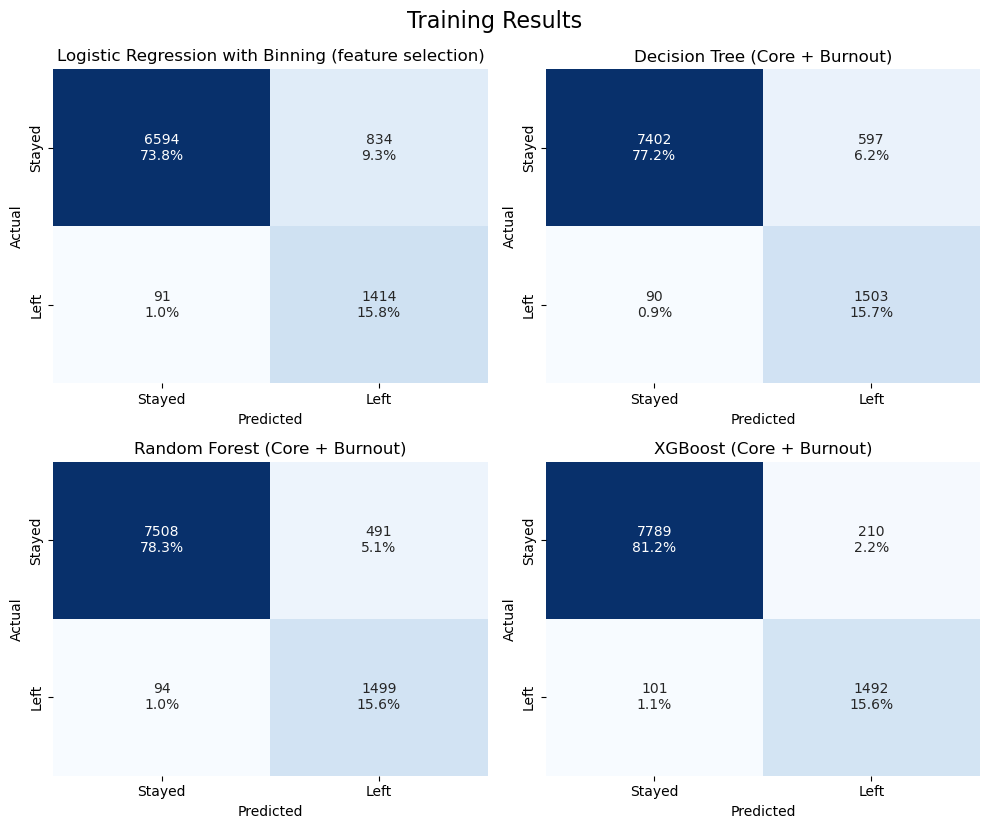

In [52]:
# plot confusion matrices for test results

# before (training/cv results)
plot_confusion_grid_from_results(results_training, png_title="Training Results")

Recall that the holdout test set was 20% of the total data, with training accounting for 80%

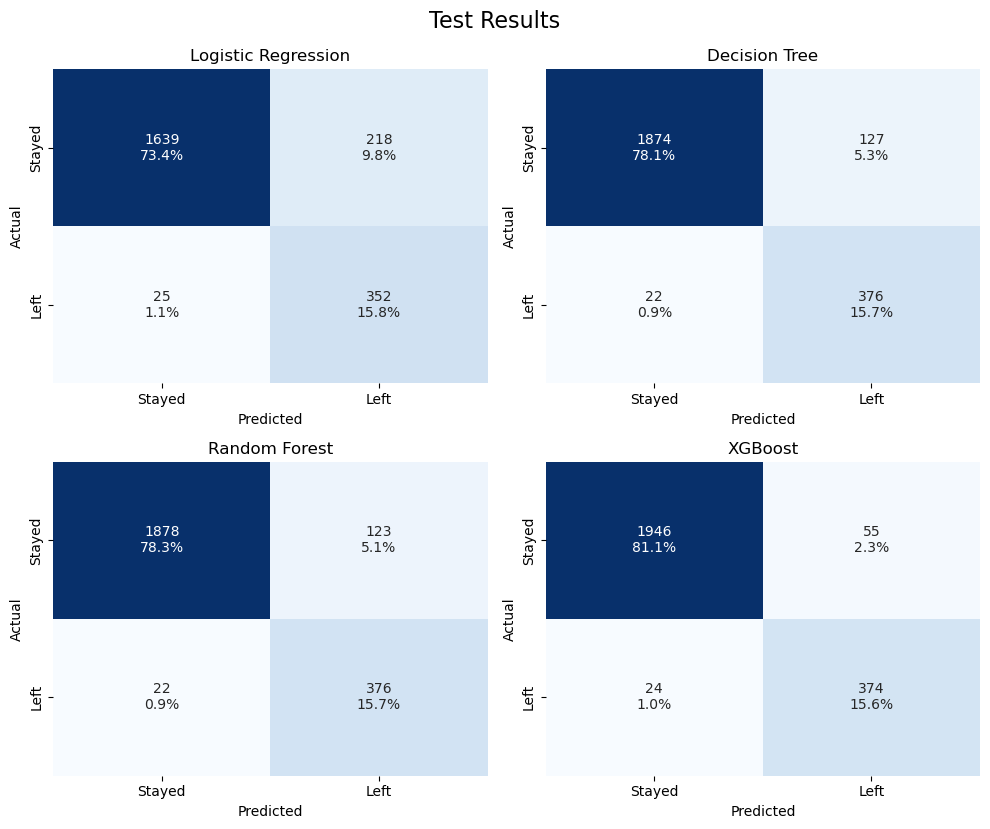

In [53]:
# after (test results)
plot_confusion_grid_from_results(results_test, png_title="Test Results")

In [54]:
# save the final results dataframe to a CSV file
results_test.to_csv("../results/test_model_evaluation_results.csv", index=False)

# print the final results dataframe
results_test

,Model,Accuracy,Precision,Recall,F1,F2,ROC AUC,Confusion Matrix,Features,Best Params
0,Logistic Regression,0.891226,0.617544,0.933687,0.743400,0.846968,0.948275,"[[1639, 218], [25, 352]]",6,"{'model__C': 0.1, 'model__class_weight': 'bala..."
1,Decision Tree,0.937891,0.747515,0.944724,0.834628,0.897375,0.956471,"[[1874, 127], [22, 376]]",7,"{'model__class_weight': 'balanced', 'model__ma..."
2,Random Forest,0.939558,0.753507,0.944724,0.838350,0.899091,0.978260,"[[1878, 123], [22, 376]]",7,"{'model__n_estimators': 300, 'model__min_sampl..."
3,XGBoost,0.967070,0.871795,0.939698,0.904474,0.925285,0.982202,"[[1946, 55], [24, 374]]",7,"{'model__subsample': 1.0, 'model__scale_pos_we..."


<p class="center-icons">
  <i class="fa fa-circle spacer-icons"></i>
  <i class="fa fa-circle spacer-icons"></i>
  <i class="fa fa-circle spacer-icons"></i>
</p>

<a id="model-interpretation"></a>

## **Model Interpretation**

[Back to top](#)

<a id="logistic-regression-interpretation"></a>

## &#8227; Logistic Regression Interpretation

[Back to top](#)

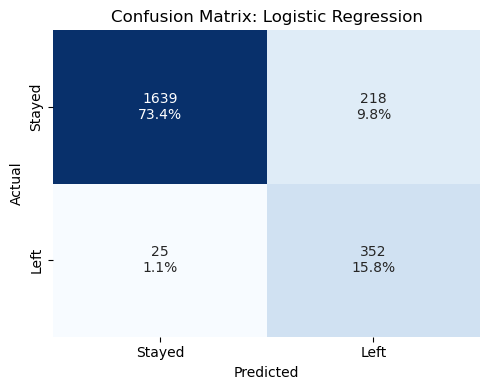

In [127]:
# plot confusion matrix for logistic regression
plot_confusion_from_results(
    results_test[results_test["Model"] == "Logistic Regression"]
)

In [128]:
def print_logistic_regression_coefficients(model, feature_names, top_n=None):
    """
    Print the coefficients (with sign) for a fitted logistic regression model.
    Args:
        model: Fitted LogisticRegression or pipeline with 'model' step.
        feature_names: List or index of feature names.
        top_n: If set, print only the top_n features by absolute value.
    """
    # If model is a pipeline, get the estimator
    if hasattr(model, "named_steps"):
        estimator = model.named_steps["model"]
    else:
        estimator = model

    if not hasattr(estimator, "coef_"):
        print("Provided model does not have coefficients.")
        return

    coefs = estimator.coef_[0]
    features = np.array(feature_names)
    # Sort by absolute value
    sorted_idx = np.argsort(np.abs(coefs))[::-1]
    if top_n is not None:
        sorted_idx = sorted_idx[:top_n]

    print(f"{'Feature':<30} {'Coefficient':>12}")
    print("-" * 44)
    for idx in sorted_idx:
        print(f"{features[idx]:<30} {coefs[idx]:>12.4f}")


# print coefficients for the best logistic regression model
print_logistic_regression_coefficients(lr_model, X_test_lr_fs_binned.columns, top_n=14)

Feature                         Coefficient
--------------------------------------------
projects_bin_medium                 -2.1431
tenure                               1.8606
hours_bin_medium                    -1.4719
projects_bin_high                   -1.2607
hours_bin_high                      -1.2555
average_monthly_hours                1.2476
satisfaction_level                  -1.0716
satisfaction_bin_high                0.7924
tenure_bin_mid                      -0.6503
number_project                       0.6464
last_evaluation                      0.3571
promotion_last_5years               -0.1311
satisfaction_bin_medium              0.0489
tenure_bin_long                      0.0000


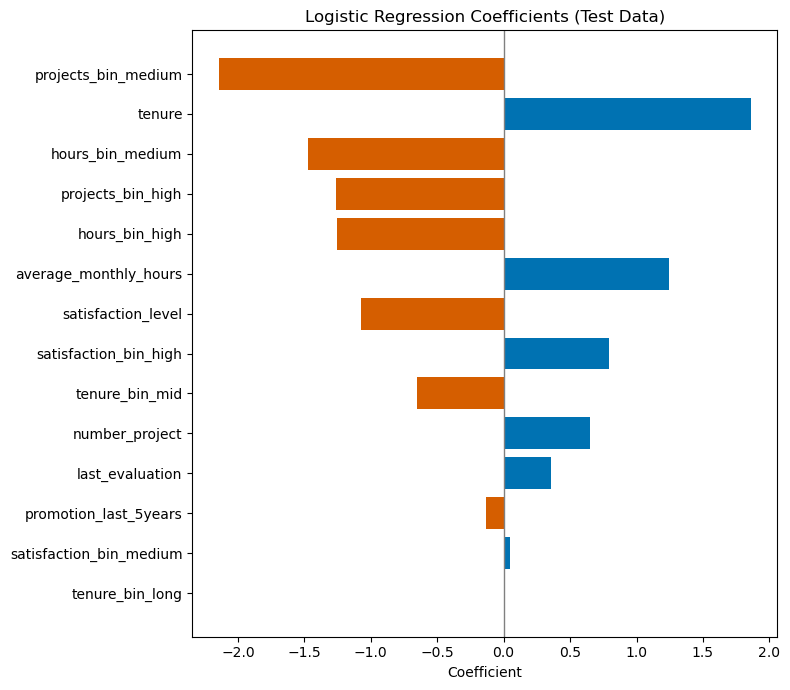

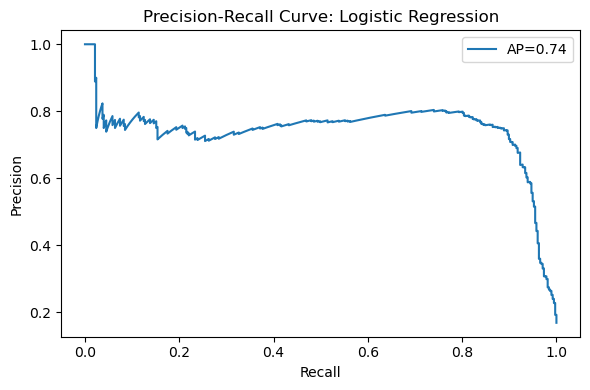

In [129]:
# plot logistic regression coefficients and precision-recall curve
lr_tuple = next((tpl for tpl in model_list if tpl[0] == "Logistic Regression"), None)
if lr_tuple:
    name, model, X_test, y_test, feature_names = lr_tuple
    # plot coefficients
    plot_logistic_regression_coefficients(
        model,
        feature_names,
        top_n=14,
        save_png=True,
        title="Logistic Regression Coefficients (Test Data)",
    )
    # plot precision-recall curve
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        plot_precision_recall_curve(y_test, y_proba, name)

In [130]:
# logistic regression's misclassified cases
df_mis = pd.read_csv("../results/misclassified_cases_logistic_regression.csv")
for label, group in df_mis.groupby("actual"):
    print(f"\nMisclassified cases where actual = {label} ({'Stayed' if label == 0 else 'Left'}):")
    print(group.describe(include="all"))


Misclassified cases where actual = 0 (Stayed):
       satisfaction_level  last_evaluation  number_project  \
count          218.000000       218.000000      218.000000   
mean             0.457431         0.721789        3.706422   
std              0.257410         0.172204        1.567544   
min              0.120000         0.360000        2.000000   
25%              0.210000         0.590000        2.000000   
50%              0.415000         0.730000        4.000000   
75%              0.667500         0.867500        5.000000   
max              1.000000         1.000000        6.000000   

       average_monthly_hours      tenure  promotion_last_5years  actual  \
count             218.000000  218.000000             218.000000   218.0   
mean              205.894495    4.082569               0.004587     0.0   
std                56.246600    0.946772               0.067729     0.0   
min                99.000000    2.000000               0.000000     0.0   
25%               

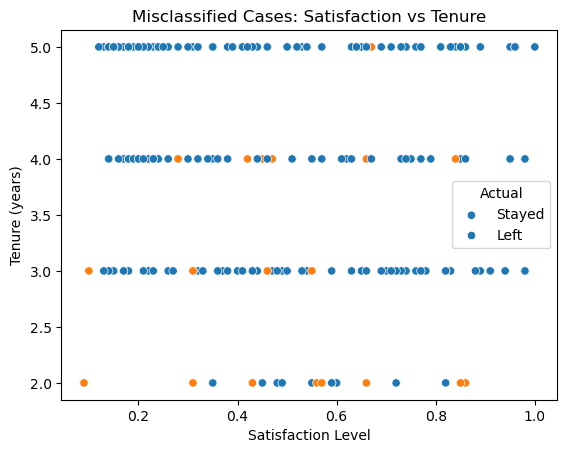

In [131]:
# scatter plot: satisfaction vs tenure
sns.scatterplot(
    data=df_mis,
    x="satisfaction_level",
    y="tenure",
    hue="actual",
)
plt.title("Misclassified Cases: Satisfaction vs Tenure")
plt.xlabel("Satisfaction Level")
plt.ylabel("Tenure (years)")
plt.legend(title="Actual", labels=["Stayed", "Left"])
plt.show()

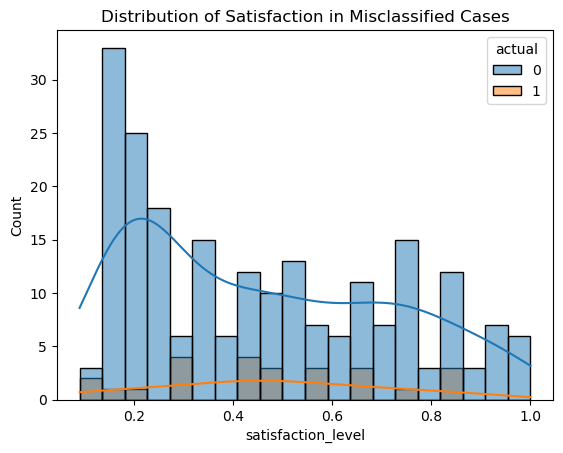

In [132]:
# Histogram of satisfaction for misclassified cases
sns.histplot(data=df_mis, x="satisfaction_level", hue="actual", kde=True, bins=20)
plt.title("Distribution of Satisfaction in Misclassified Cases")
plt.show()

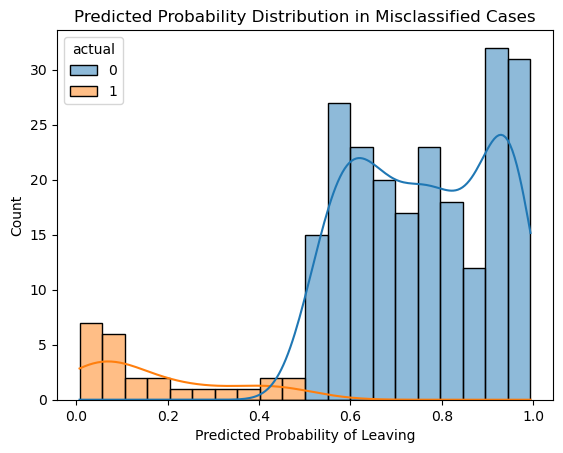

In [133]:
sns.histplot(data=df_mis, x="predicted_proba", hue="actual", bins=20, kde=True)
plt.title("Predicted Probability Distribution in Misclassified Cases")
plt.xlabel("Predicted Probability of Leaving")
plt.show()

<a id="decision-tree-interpretation"></a>

## &#8227; Decision Tree Interpretation

[Back to top](#)

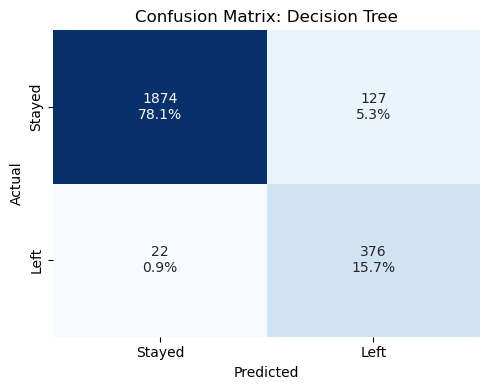

In [134]:
# plot confusion matrix for decision tree
plot_confusion_from_results(results_test[results_test["Model"] == "Decision Tree"])

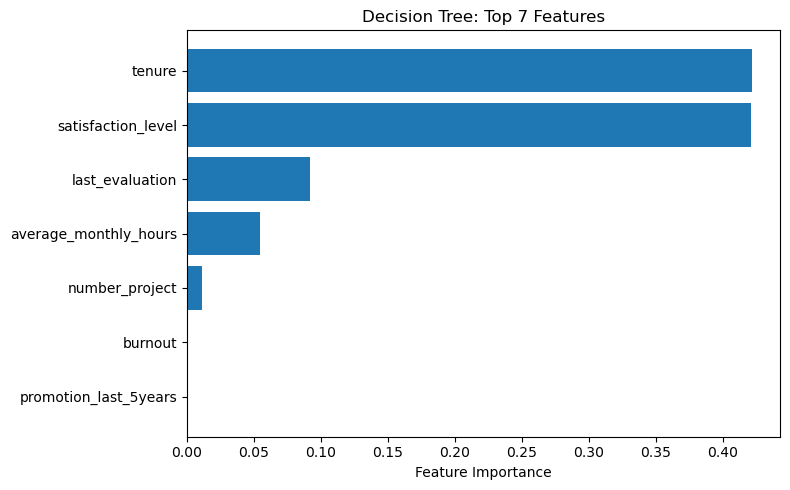

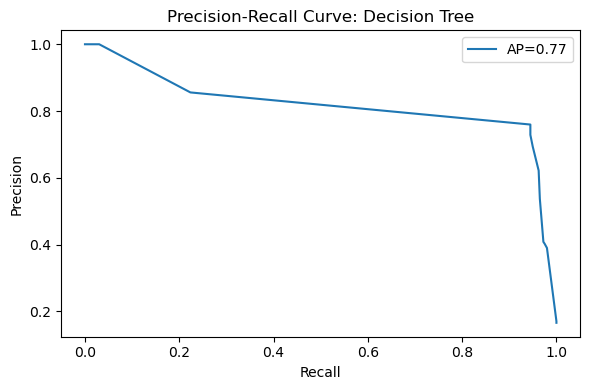

In [135]:
# plot feature importances and precision-recall curve for Decision Tree model
dt_tuple = next((tpl for tpl in model_list if tpl[0] == "Decision Tree"), None)
if dt_tuple:
    name, model, X_test, y_test, feature_names = dt_tuple
    file_name = f"best_{name.replace(' ', '_').lower()}_model.joblib"
    load_and_plot_feature_importance(file_name, name, feature_names, save_png=True)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        plot_precision_recall_curve(y_test, y_proba, name)

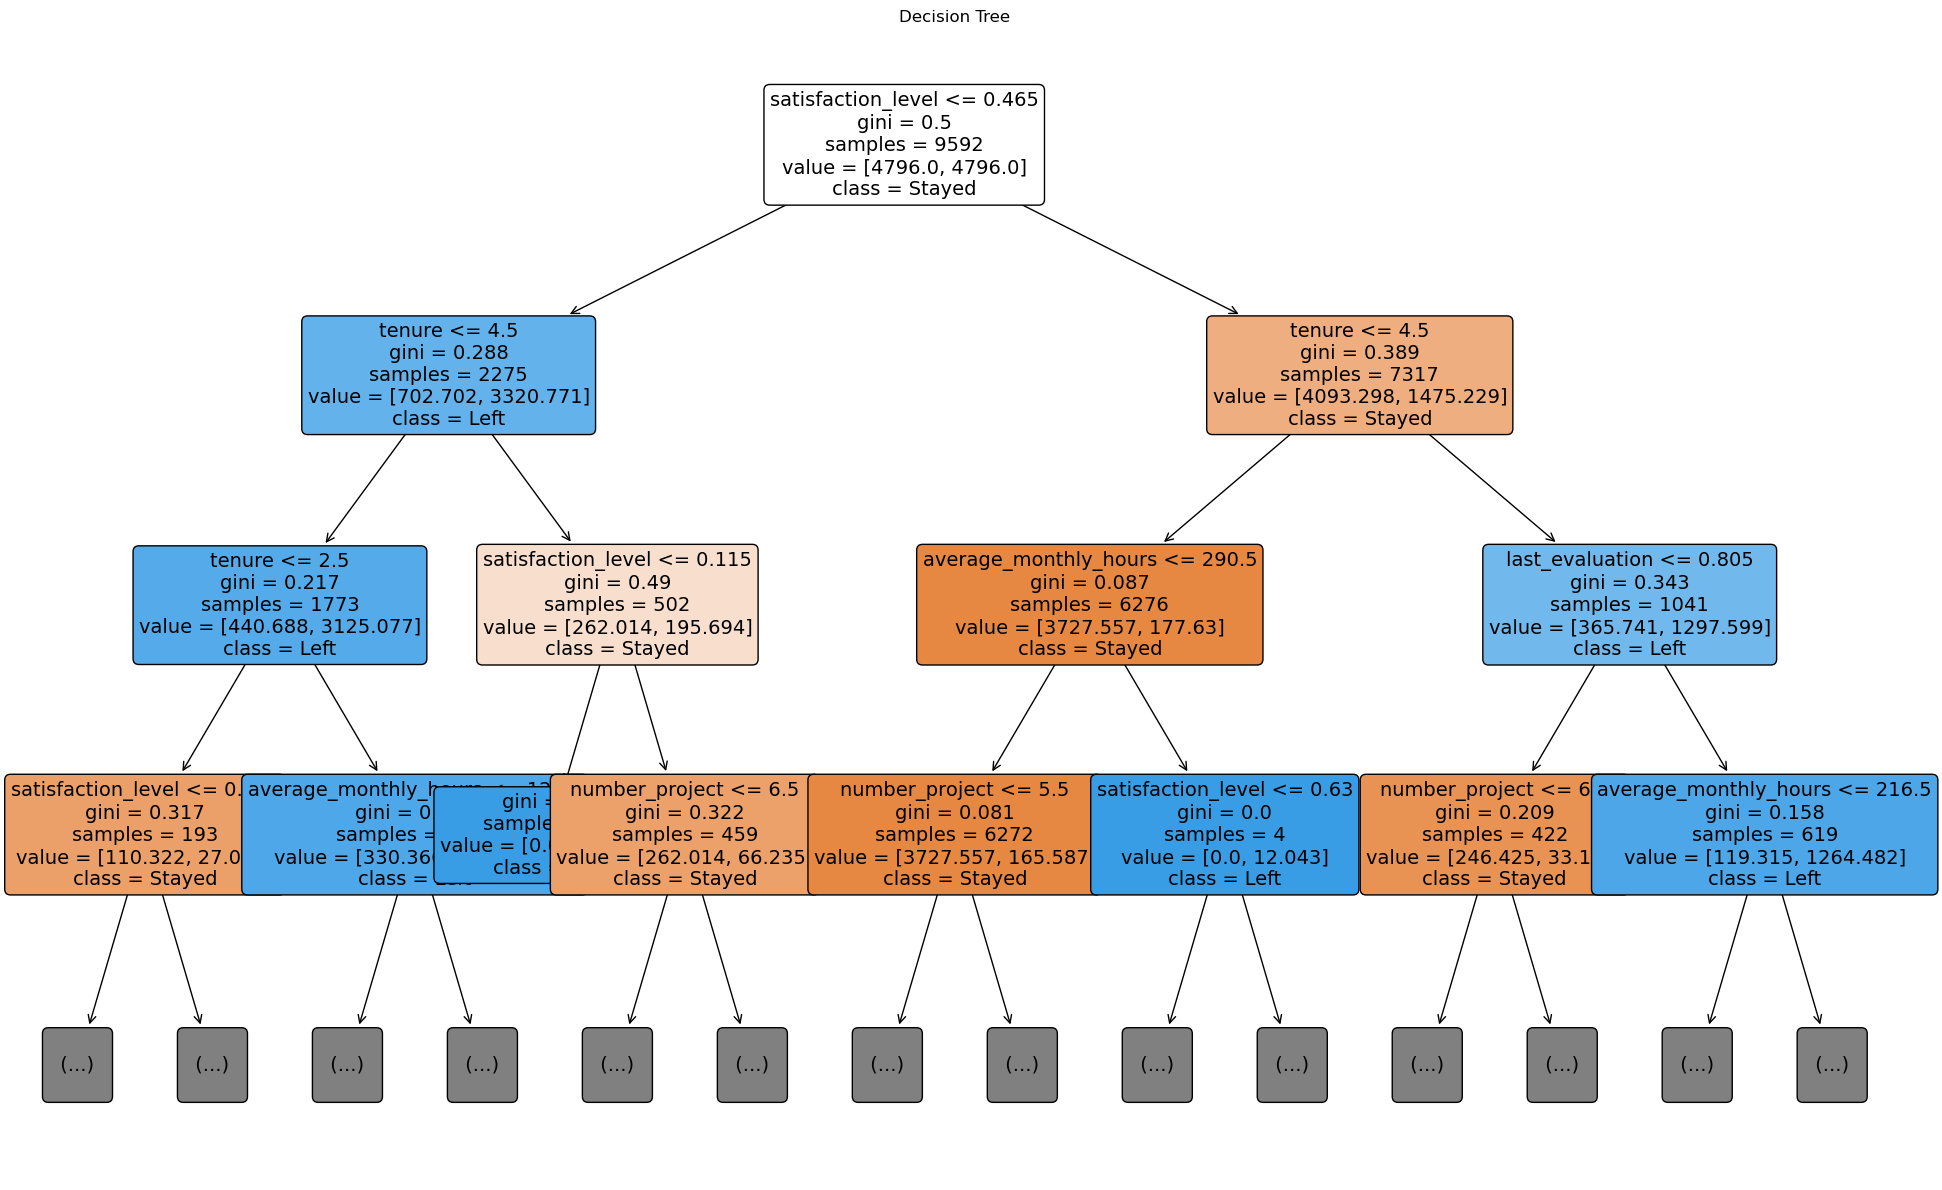

In [136]:
# load decision tree model and plot the tree

dt_model = joblib.load("../results/saved_models/best_decision_tree_model.joblib")
estimator = dt_model.named_steps["model"]

# ensure feature_names matches columns used for training
# sklearn requires a list of strings, not a pandas index or series
feature_names = list(X_test_tree.columns)

plt.figure(figsize=(20, 12))
plot_tree(
    estimator,
    feature_names=feature_names,
    class_names=["Stayed", "Left"],
    filled=True,
    rounded=True,
    max_depth=3,
    fontsize=14,
)
plt.title("Decision Tree")
plt.tight_layout()

plt.savefig("../results/images/best_decision_tree_model_visualization.png")

plt.show()

In [137]:
import re
from sklearn.tree import export_text
from IPython.display import display, HTML

dt_model = joblib.load("../results/saved_models/best_decision_tree_model.joblib")
estimator = dt_model.named_steps["model"]

tree_rules = export_text(estimator, feature_names=list(X_test_tree.columns))
tree_rules = tree_rules.replace("class: 0", "class: Stayed").replace(
    "class: 1", "class: Left"
)

feature_colors = {
    "satisfaction_level": "#1f77b4",
    "last_evaluation": "#ff7f0e",
    "number_project": "#2ca02c",
    "average_monthly_hours": "#d62728",
    "tenure": "#9467bd",
    "promotion_last_5years": "#8c564b",
    "burnout": "#e377c2",
}

html_lines = []
for line in tree_rules.splitlines():
    indent = len(line) - len(line.lstrip())
    content = line.strip()
    # use regex to extract feature name
    match = re.search(r"([a-zA-Z_][a-zA-Z0-9_]*)\s*[<>=]", content)
    feature = match.group(1) if match else None
    color = feature_colors.get(feature, "#333")
    if "class:" in content:
        html_line = (
            f'<div style="margin-left:{indent*18}px;'
            "background:#e6ffe6;"
            "border-radius:6px;"
            "padding:2px 8px;"
            "margin-bottom:2px;"
            "font-weight:bold;"
            "color:#20732d;"
            'box-shadow:0 1px 4px #b2dfdb;">'
            f'<span title="Leaf node">🍃</span> {content}'
            "</div>"
        )
    else:
        html_line = (
            f'<div style="margin-left:{indent*18}px;'
            f"color:{color};"
            "padding:2px 8px;"
            "margin-bottom:2px;"
            "border-left:3px solid #eee;"
            'transition:background 0.2s;"'
            f" onmouseover=\"this.style.background='#f0f8ff'\" onmouseout=\"this.style.background=''\">"
            f'<span title="Split node">🌳</span> <b>{content}</b>'
            "</div>"
        )
    html_lines.append(html_line)
html_tree = "\n".join(html_lines)

custom_css = """
<style>
.tree-scroll { max-height: 600px; overflow-y: auto; border: 1px solid #ddd; border-radius: 8px; background: #fafbfc; padding: 10px; }
</style>
"""

display(
    HTML(
        custom_css
        + f'<div class="tree-scroll" style="font-family:monospace;white-space:pre;line-height:1.5;">{html_tree}</div>'
    )
)

In [138]:
# decision tree's misclassified cases
df_mis = pd.read_csv("../results/misclassified_cases_decision_tree.csv")
for label, group in df_mis.groupby("actual"):
    print(f"\nMisclassified cases where actual = {label} ({'Stayed' if label == 0 else 'Left'}):")
    print(group.describe(include="all"))


Misclassified cases where actual = 0 (Stayed):
        satisfaction_level  last_evaluation  number_project  \
count           127.000000       127.000000      127.000000   
unique                 NaN              NaN             NaN   
top                    NaN              NaN             NaN   
freq                   NaN              NaN             NaN   
mean              0.312677         0.750472        4.228346   
std               0.171077         0.155374        1.310452   
min               0.120000         0.450000        2.000000   
25%               0.190000         0.640000        3.000000   
50%               0.270000         0.760000        5.000000   
75%               0.375000         0.870000        5.000000   
max               0.900000         1.000000        6.000000   

        average_monthly_hours      tenure  promotion_last_5years burnout  \
count              127.000000  127.000000             127.000000     127   
unique                    NaN         NaN  

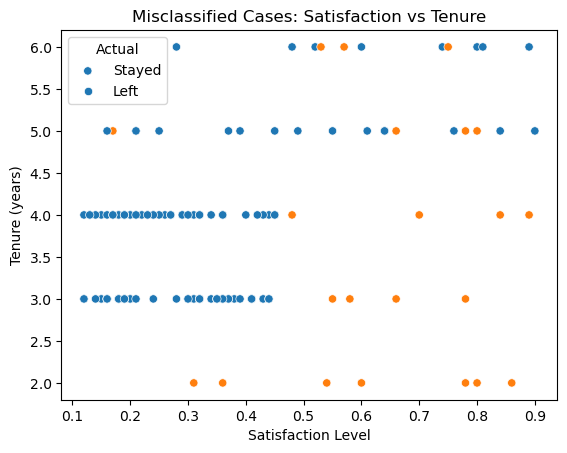

In [139]:
# scatter plot: satisfaction vs tenure
sns.scatterplot(
    data=df_mis,
    x="satisfaction_level",
    y="tenure",
    hue="actual",
)
plt.title("Misclassified Cases: Satisfaction vs Tenure")
plt.xlabel("Satisfaction Level")
plt.ylabel("Tenure (years)")
plt.legend(title="Actual", labels=["Stayed", "Left"])
plt.show()

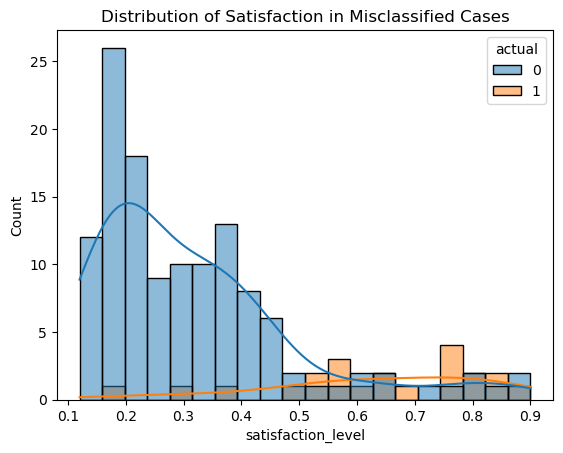

In [140]:
# Histogram of satisfaction for misclassified cases
sns.histplot(data=df_mis, x="satisfaction_level", hue="actual", kde=True, bins=20)
plt.title("Distribution of Satisfaction in Misclassified Cases")
plt.show()

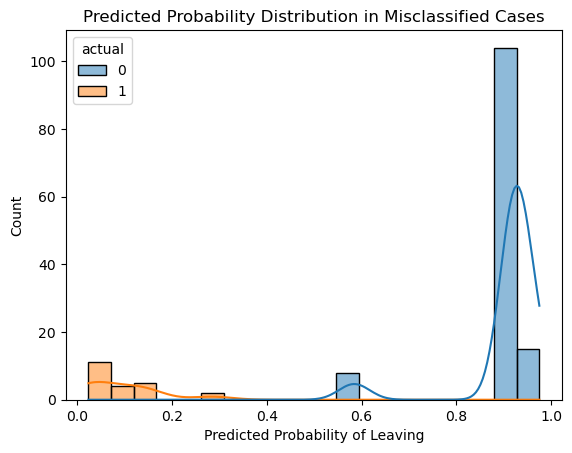

In [141]:
sns.histplot(data=df_mis, x="predicted_proba", hue="actual", bins=20, kde=True)
plt.title("Predicted Probability Distribution in Misclassified Cases")
plt.xlabel("Predicted Probability of Leaving")
plt.show()

<a id="random-forest-interpretation"></a>

## &#8227; Random Forest Interpretation

[Back to top](#)

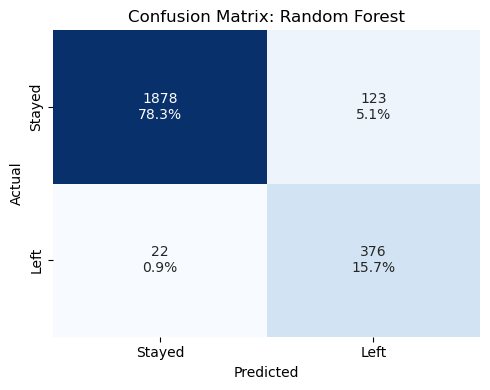

In [142]:
# plot confusion matrix for random forest
plot_confusion_from_results(results_test[results_test["Model"] == "Random Forest"])

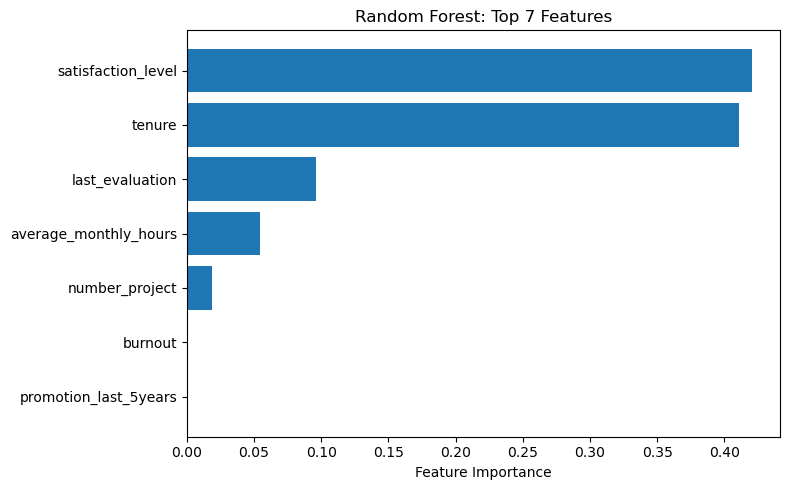

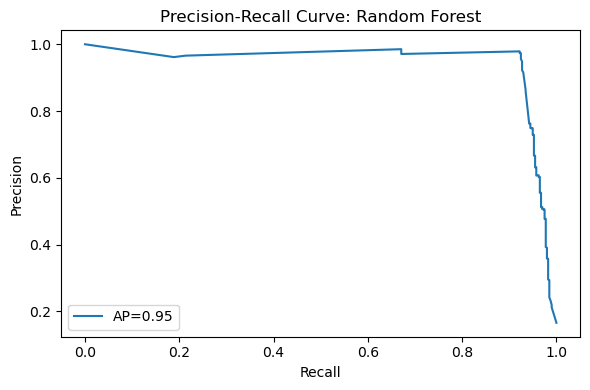

In [143]:
# plot feature importances and precision-recall curve for random forest model
rf_tuple = next((tpl for tpl in model_list if tpl[0] == "Random Forest"), None)
if rf_tuple:
    name, model, X_test, y_test, feature_names = rf_tuple
    file_name = f"best_{name.replace(' ', '_').lower()}_model.joblib"
    load_and_plot_feature_importance(file_name, name, feature_names, save_png=True)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        plot_precision_recall_curve(y_test, y_proba, name)

In [144]:
# random forest's misclassified cases
df_mis = pd.read_csv("../results/misclassified_cases_random_forest.csv")
for label, group in df_mis.groupby("actual"):
    print(f"\nMisclassified cases where actual = {label} ({'Stayed' if label == 0 else 'Left'}):")
    print(group.describe(include="all"))


Misclassified cases where actual = 0 (Stayed):
        satisfaction_level  last_evaluation  number_project  \
count           123.000000       123.000000      123.000000   
unique                 NaN              NaN             NaN   
top                    NaN              NaN             NaN   
freq                   NaN              NaN             NaN   
mean              0.315854         0.750813        4.203252   
std               0.172755         0.152157        1.317968   
min               0.120000         0.450000        2.000000   
25%               0.190000         0.645000        3.000000   
50%               0.270000         0.760000        5.000000   
75%               0.385000         0.870000        5.000000   
max               0.900000         1.000000        6.000000   

        average_monthly_hours      tenure  promotion_last_5years burnout  \
count              123.000000  123.000000             123.000000     123   
unique                    NaN         NaN  

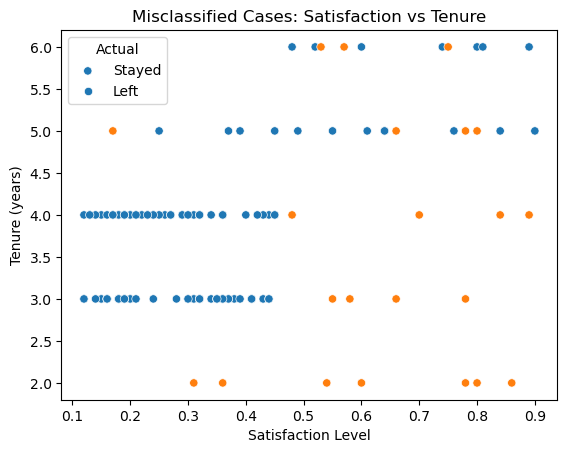

In [145]:
# scatter plot: satisfaction vs tenure
sns.scatterplot(
    data=df_mis,
    x="satisfaction_level",
    y="tenure",
    hue="actual",
)
plt.title("Misclassified Cases: Satisfaction vs Tenure")
plt.xlabel("Satisfaction Level")
plt.ylabel("Tenure (years)")
plt.legend(title="Actual", labels=["Stayed", "Left"])
plt.show()

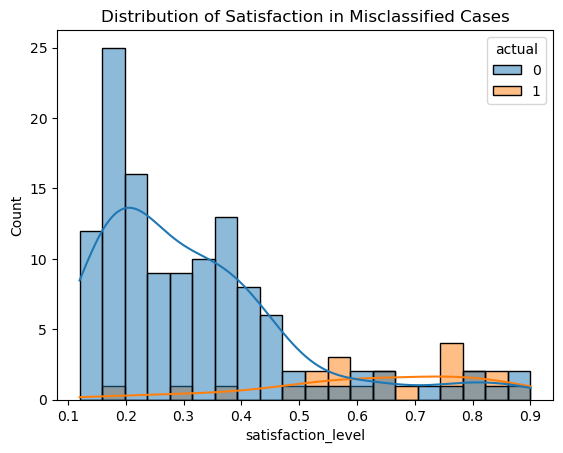

In [146]:
# Histogram of satisfaction for misclassified cases
sns.histplot(data=df_mis, x="satisfaction_level", hue="actual", kde=True, bins=20)
plt.title("Distribution of Satisfaction in Misclassified Cases")
plt.show()

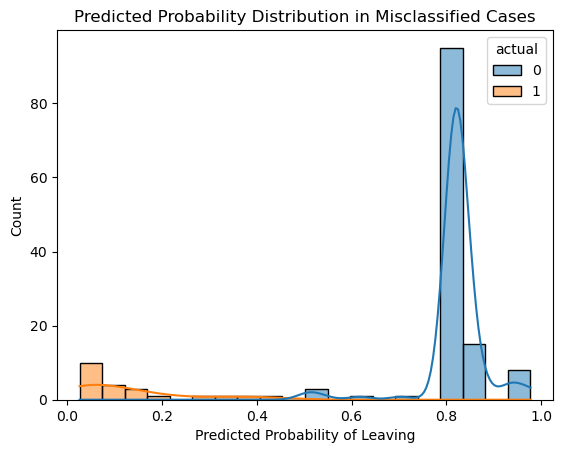

In [147]:
sns.histplot(data=df_mis, x="predicted_proba", hue="actual", bins=20, kde=True)
plt.title("Predicted Probability Distribution in Misclassified Cases")
plt.xlabel("Predicted Probability of Leaving")
plt.show()

<a id="xgboost-interpretation"></a>

## &#8227; XGBoost Interpretation

[Back to top](#)

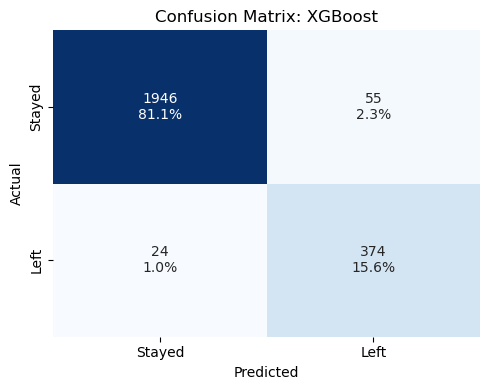

In [148]:
# plot confusion matrix for xgboost
plot_confusion_from_results(results_test[results_test["Model"] == "XGBoost"])

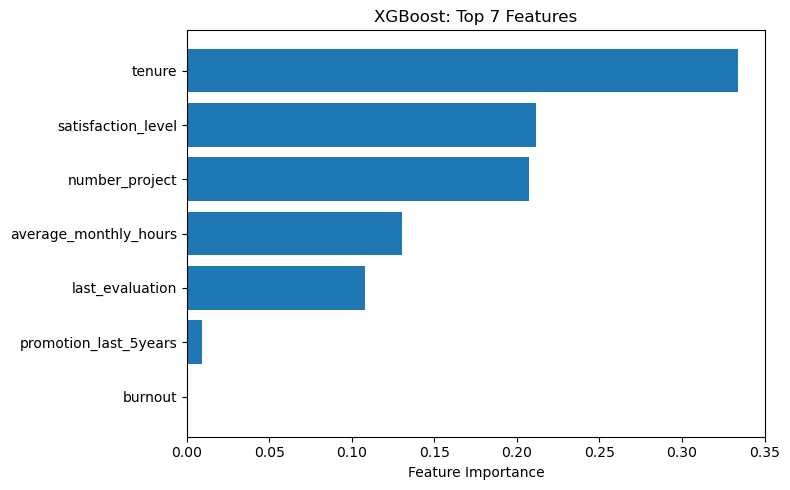

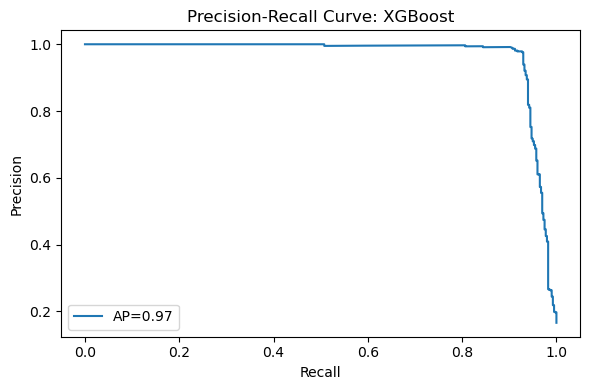

In [149]:
# plot feature importances and precision-recall curve for XGBoost model
xgb_tuple = next((tpl for tpl in model_list if tpl[0] == "XGBoost"), None)
if xgb_tuple:
    name, model, X_test, y_test, feature_names = xgb_tuple
    file_name = f"best_{name.replace(' ', '_').lower()}_model.joblib"
    load_and_plot_feature_importance(file_name, name, feature_names, save_png=True)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        plot_precision_recall_curve(y_test, y_proba, name)

In [150]:
# xgboost's misclassified cases
df_mis = pd.read_csv("../results/misclassified_cases_xgboost.csv")
for label, group in df_mis.groupby("actual"):
    print(f"\nMisclassified cases where actual = {label} ({'Stayed' if label == 0 else 'Left'}):")
    print(group.describe(include="all"))


Misclassified cases where actual = 0 (Stayed):
        satisfaction_level  last_evaluation  number_project  \
count            55.000000        55.000000       55.000000   
unique                 NaN              NaN             NaN   
top                    NaN              NaN             NaN   
freq                   NaN              NaN             NaN   
mean              0.581091         0.748545        3.836364   
std               0.217295         0.185227        1.500168   
min               0.130000         0.450000        2.000000   
25%               0.380000         0.550000        2.000000   
50%               0.570000         0.810000        4.000000   
75%               0.805000         0.900000        5.000000   
max               0.900000         1.000000        6.000000   

        average_monthly_hours     tenure  promotion_last_5years burnout  \
count               55.000000  55.000000              55.000000      55   
unique                    NaN        NaN     

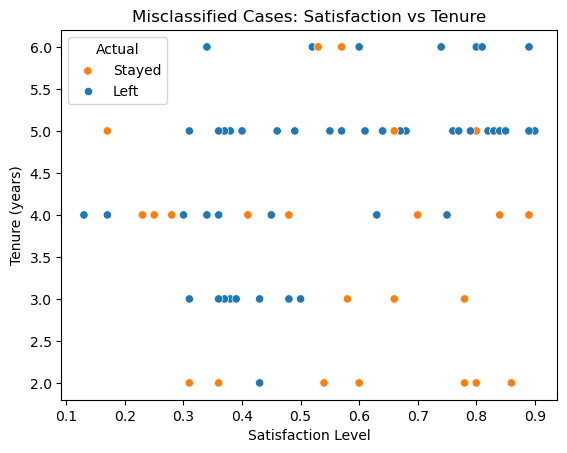

In [151]:
# scatter plot: satisfaction vs tenure
sns.scatterplot(
    data=df_mis,
    x="satisfaction_level",
    y="tenure",
    hue="actual",
)
plt.title("Misclassified Cases: Satisfaction vs Tenure")
plt.xlabel("Satisfaction Level")
plt.ylabel("Tenure (years)")
plt.legend(title="Actual", labels=["Stayed", "Left"])
plt.show()

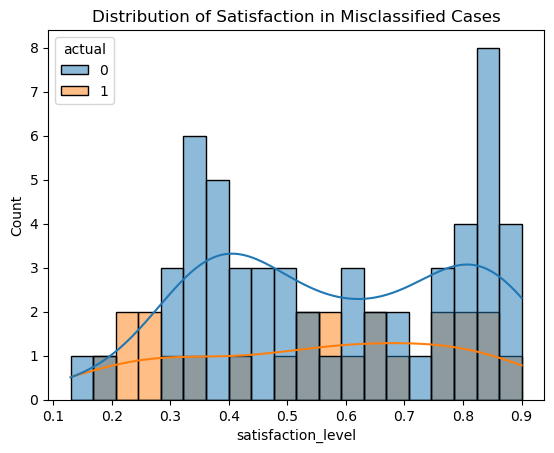

In [152]:
# Histogram of satisfaction for misclassified cases
sns.histplot(data=df_mis, x="satisfaction_level", hue="actual", kde=True, bins=20)
plt.title("Distribution of Satisfaction in Misclassified Cases")
plt.show()

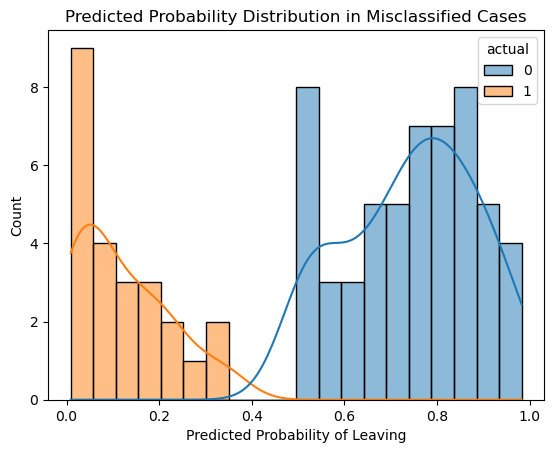

In [153]:
sns.histplot(data=df_mis, x="predicted_proba", hue="actual", bins=20, kde=True)
plt.title("Predicted Probability Distribution in Misclassified Cases")
plt.xlabel("Predicted Probability of Leaving")
plt.show()

<p class="center-icons">
  <i class="fa fa-circle spacer-icons"></i>
  <i class="fa fa-circle spacer-icons"></i>
  <i class="fa fa-circle spacer-icons"></i>
</p>

<a id="conclusion"></a>

## **Conclusion**

[Back to top](#)

## Recall evaluation metrics

- **AUC** is the area under the ROC curve; it's also considered the probability that the model ranks a random positive example more highly than a random negative example.
- **Precision** measures the proportion of data points predicted as True that are actually True, in other words, the proportion of positive predictions that are true positives.
- **Recall** measures the proportion of data points that are predicted as True, out of all the data points that are actually True. In other words, it measures the proportion of positives that are correctly classified.
- **Accuracy** measures the proportion of data points that are correctly classified.
- **F1-score** is an aggregation of precision and recall.






> ### Execute Stage Reflection
> 
> #### What key insights emerged from your model(s)?
> - **Satisfaction level** and **workload** (number of projects, monthly hours) are the strongest predictors of attrition.
> - Two main at-risk groups: **overworked/burned-out employees** (many projects, long hours, low satisfaction) and **underworked/disengaged employees** (few projects, low satisfaction).
> - **Tenure** is important: attrition peaks at 4–5 years, then drops sharply.
> - **Salary, department, and recent promotions** have minimal predictive value.
> - **Tree-based models (Random Forest, XGBoost)** achieved the best balance of recall, precision, and F1. With feature engineering, **logistic regression** became competitive and highly interpretable.
> 
> #### What business recommendations do you propose based on the models built?
> - **Monitor satisfaction and workload:** Regularly survey employees and track workload to identify those at risk of burnout or disengagement.
> - **Targeted retention efforts:** Focus on employees with low satisfaction and extreme workloads, especially those at the 4–5 year tenure mark.
> - **Promotions and recognition:** Consider more frequent recognition or advancement opportunities.
> - **Work-life balance:** Encourage reasonable project loads and monthly hours to reduce burnout risk.
> 
> #### What potential recommendations would you make to your manager/company?
> - **Implement early warning systems** using the model to flag at-risk employees for supportive HR outreach.
> - **Review workload distribution** and ensure fair, manageable assignments.
> - **Conduct stay interviews** with employees approaching 4–5 years of tenure.
> - **Communicate transparently** about how predictive models are used, emphasizing support rather than punitive action.
> 
> #### Do you think your model could be improved? Why or why not? How?
> - **Feature engineering:** Further refine interaction terms or add time-based features if available.
> - **External data:** Incorporate additional data (e.g., engagement surveys, manager ratings, exit interview themes).
> - **Model calibration:** Regularly retrain and calibrate the model as new data becomes available.
> - **Bias audits:** Routinely check for bias across demographic groups.
> 
> #### Given what you know about the data and the models you were using, what other questions could you address for the team?
> - What are the specific reasons for attrition in different departments or roles?
> - Are there seasonal or cyclical patterns in attrition?
> - How do external factors (e.g., economic conditions, industry trends) affect turnover?
> - What interventions are most effective for retaining at-risk employees?
> 
> #### What resources do you find yourself using as you complete this stage? (Make sure to include the links.)
> - [pandas documentation](https://pandas.pydata.org/docs/)
> - [matplotlib documentation](https://matplotlib.org/stable/users/index.html)
> - [seaborn documentation](https://seaborn.pydata.org/)
> - [scikit-learn documentation](https://scikit-learn.org/stable/user_guide.html)
> - [XGBoost documentation](https://xgboost.readthedocs.io/en/stable/)
> - [Kaggle HR Analytics Dataset](https://www.kaggle.com/datasets/mfaisalqureshi/hr-analytics-and-job-prediction?select=HR_comma_sep.csv)
> 
> #### Do you have any ethical considerations in this stage?
> - **Data privacy:** Ensure employee data is kept confidential and secure.
> - **Fairness:** Avoid using the model to unfairly target or penalize specific groups.
> - **Transparency:** Clearly communicate how predictions are generated and used.
> - **Supportive use:** Use predictions to offer support and resources, not for punitive measures.
> - **Ongoing monitoring:** Regularly audit the model for bias and unintended consequences.

### Conclusion, Recommendations, Next Steps

> ### Conclusion
> - **Satisfaction level** and **workload** (number of projects, monthly hours) are the strongest predictors of employee attrition.
> - Two main at-risk groups emerged: **overworked/burned-out employees** (many projects, long hours, low satisfaction) and **underworked/disengaged employees** (few projects, low satisfaction).
> - **Tenure** is important: attrition peaks at 4–5 years, then drops sharply.
> - **Salary, department, and recent promotions** have minimal predictive value.
> - **Tree-based models (Random Forest, XGBoost)** achieved the best balance of recall, precision, and F1. With feature engineering, **logistic regression** became competitive and highly interpretable.
> 
> ### Recommendations
> - **Monitor satisfaction and workload:** Regularly survey employees and track workload to identify those at risk of burnout or disengagement.
> - **Targeted retention efforts:** Focus on employees with low satisfaction and extreme workloads, especially those at the 4–5 year tenure mark.
> - **Promotions and recognition:** Consider more frequent recognition or advancement opportunities.
> - **Work-life balance:** Encourage reasonable project loads and monthly hours to reduce burnout risk.
> - **Implement early warning systems:** Use the model to flag at-risk employees for supportive HR outreach.
> - **Review workload distribution:** Ensure fair, manageable assignments.
> - **Conduct stay interviews:** Engage employees approaching 4–5 years of tenure.
> - **Communicate transparently:** Clearly explain how predictive models are used, emphasizing support rather than punitive action.
> 
> ### Next Steps
> - **Model deployment:** Integrate the predictive model into HR processes for early identification of at-risk employees.
> - **Continuous improvement:** Regularly retrain and calibrate the model as new data becomes available.
> - **Expand data sources:** Incorporate additional data (e.g., engagement surveys, manager ratings, exit interview themes) to improve model accuracy.
> - **Bias and fairness audits:** Routinely check for bias across demographic groups and monitor for unintended consequences.
> - **Ethical safeguards:** Ensure employee data privacy, fairness, and transparency in all predictive analytics initiatives.
> 
> ---
> **Resources Used:**
> - [pandas documentation](https://pandas.pydata.org/docs/)
> - [matplotlib documentation](https://matplotlib.org/stable/users/index.html)
> - [seaborn documentation](https://seaborn.pydata.org/)
> - [scikit-learn documentation](https://scikit-learn.org/stable/user_guide.html)
> - [XGBoost documentation](https://xgboost.readthedocs.io/en/stable/)
> - [Kaggle HR Analytics Dataset](https://www.kaggle.com/datasets/mfaisalqureshi/hr-analytics-and-job-prediction?select=HR_comma_sep.csv)

<a id="appendix-data-dictionary"></a>

# Appendix: Data Dictionary
---

[Back to top](#)

The dataset contains 15,000 rows and 10 columns for the variables listed below. 

**Note:** For more information about the data, refer to its source on [Kaggle](https://www.kaggle.com/datasets/mfaisalqureshi/hr-analytics-and-job-prediction?select=HR_comma_sep.csv).

Variable  |Description |
-----|-----|
satisfaction_level|Employee-reported job satisfaction level [0&ndash;1]|
last_evaluation|Score of employee's last performance review [0&ndash;1]|
number_project|Number of projects employee contributes to|
average_monthly_hours|Average number of hours employee worked per month|
time_spend_company|How long the employee has been with the company (years)
Work_accident|Whether or not the employee experienced an accident while at work
left|Whether or not the employee left the company
promotion_last_5years|Whether or not the employee was promoted in the last 5 years
Department|The employee's department
salary|The employee's salary (U.S. dollars)

### Feature Engineering Data Dictionary


The following table describes the engineered features created for model development. These features are derived from the original dataset using binning, interaction terms, and logical flags to capture important patterns identified during exploratory data analysis.

Variable  |Description |
-----|-----|
**Bins** | |
satisfaction_bin_low | Binary indicator: satisfaction_level is low (≤ 0.4) |
satisfaction_bin_medium | Binary indicator: satisfaction_level is medium (> 0.4 and ≤ 0.7) |
satisfaction_bin_high | Binary indicator: satisfaction_level is high (> 0.7) |
hours_bin_low | Binary indicator: average_monthly_hours is low (≤ 160) |
hours_bin_medium | Binary indicator: average_monthly_hours is medium (> 160 and ≤ 240) |
hours_bin_high | Binary indicator: average_monthly_hours is high (> 240) |
projects_bin_low | Binary indicator: number_project is low (≤ 2) |
projects_bin_medium | Binary indicator: number_project is medium (> 2 and ≤ 5) |
projects_bin_high | Binary indicator: number_project is high (> 5) |
tenure_bin_short | Binary indicator: tenure is short (≤ 3 years) |
tenure_bin_mid | Binary indicator: tenure is mid (> 3 and ≤ 5 years) |
tenure_bin_long | Binary indicator: tenure is long (> 5 years) |
**Interactions** | |
satisfaction_x_projects | Interaction: satisfaction_level × number_project |
satisfaction_x_hours | Interaction: satisfaction_level × average_monthly_hours |
evaluation_x_satisfaction | Interaction: last_evaluation × satisfaction_level |
hours_per_project | Ratio: average_monthly_hours divided by number_project |
**Flags** | |
burnout | Flag: True if (number_project ≥ 6 or average_monthly_hours ≥ 240) and satisfaction_level ≤ 0.3 |
disengaged | Flag: True if (number_project ≤ 2 and average_monthly_hours < 160 and satisfaction_level ≤ 0.5) |
no_promo_4yr | Flag: True if promotion_last_5years == 0 and tenure ≥ 4 |

**Note:**  
Binned features are one-hot encoded as separate columns (e.g., satisfaction_bin_low, satisfaction_bin_medium, satisfaction_bin_high). Only the relevant dummy variables (excluding the first category for each bin) are included in the final dataset, depending on the encoding strategy.

<a href id="appendix-feature-engineering"></a>

# Feature Engineering
---

[Back to Top](#)

In addition to baseline models run with all original features, all feature engineering varieties below were tested with all four model types: **Logistic Regression**, **Decision Tree**, **Random Forest**, and **XGBoost**.

### Feature Engineering Round One

**Original features + binning**:
This set adds binned versions of key variables (satisfaction, workload, projects, tenure) to the original features. Binning helps capture non-linear effects and threshold-based risk groups identified in EDA (e.g., low/medium/high satisfaction, extreme workloads, tenure windows).

**Original features + interactions**:
This set augments the original features with interaction terms that capture relationships between satisfaction, workload, and performance (e.g., satisfaction × projects, satisfaction × hours, evaluation × satisfaction, hours per project). These interactions help distinguish between disengaged, overworked, and healthy employees.

**Original features + categorical flags**:
This set adds logical flag features to the original data, such as "burnout" (overworked and dissatisfied), "disengaged" (underworked and dissatisfied), and "no_promo_4yr" (long tenure without promotion). These flags directly encode high-risk employee profiles identified in EDA.

**Feature selection**:
For each of the above, a feature selection variant was also run, dropping weak predictors (department, salary, work_accident) to reduce noise and multicollinearity, especially for logistic regression.

### Feature Engineering Round Two

**Selected features + burnout flag:**
This set isolates the core predictors of attrition (satisfaction, workload, tenure, promotion) and adds a “burnout” flag to capture the high-risk group of overworked, dissatisfied employees

**Selected features + interactions:**
This set focuses on the main drivers (satisfaction, workload, tenure) and adds interaction terms (satisfaction × projects, hours per project) to capture non-linear effects and workload intensity, which EDA showed are important for distinguishing between underworked, overworked, and healthy employees.

**Selected features + interactions + burnout flag:**
This feature set combines the core predictors of attrition (satisfaction, workload, tenure) with a “burnout” flag to capture high-risk, overworked employees. It also includes a key interaction term, "satisfaction × projects", to distinguish between groups identified in EDA

<a href id="appendix-hyperparameters"></a>

## Appendix: Hyperparameter Tuning Grids
---

[Back to Top](#)

This section summarizes the hyperparameter grids used for model selection and tuning via `GridSearchCV` and `RandomizedSearchCV` for all baseline and feature-engineered models.

---

### **Logistic Regression**

**Baseline Grid:**
```python
lr_base_param_grid = {
    "Logistic Regression": {
        "model__C": [0.01, 0.1, 1.0, 10.0, 100.0],  # Regularization strength (inverse)
        "model__penalty": ["l1", "l2"],             # L1 (Lasso) or L2 (Ridge)
        "model__solver": ["liblinear"],             # Supports L1/L2
        "model__class_weight": [None, "balanced"],  # Handle class imbalance
    }
}
```

**Feature Engineering Grid:**
```python
lr_fe_params = {
    "model__C": [0.1, 1.0, 10.0],
    "model__penalty": ["l1", "l2"],
    "model__solver": ["liblinear"],
    "model__class_weight": [None, "balanced"],
}
```

---

### **Decision Tree**

**Baseline Grid:**
```python
tree_base_param_grids = {
    "Decision Tree": {
        "model__max_depth": [4, 6, 8, None],        # Max tree depth
        "model__min_samples_leaf": [1, 2, 5],       # Min samples at leaf
        "model__min_samples_split": [2, 4, 6],      # Min samples to split
        "model__class_weight": [None, "balanced"],  # Handle class imbalance
    },
    ...
}
```

**Feature Engineering Grid:**
```python
tree_fe_params = {
    "Decision Tree": {
        "model__max_depth": [3, 4, 5, 6, 8],
        "model__min_samples_leaf": [1, 2, 3],
        "model__min_samples_split": [2, 3, 4],
        "model__class_weight": [None, "balanced"],
    },
    ...
}
```

---

### **Random Forest**

**Baseline Grid:**
```python
tree_base_param_grids = {
    "Random Forest": {
        "model__n_estimators": [300, 500],          # Number of trees
        "model__max_depth": [3, 5, None],           # Max tree depth
        "model__max_features": ["sqrt", 1.0],       # Features considered at each split
        "model__max_samples": [0.7, 1.0],           # Fraction of samples per tree
        "model__min_samples_leaf": [1, 2, 3],       # Min samples at leaf
        "model__min_samples_split": [2, 3, 4],      # Min samples to split
        "model__class_weight": [None, "balanced"],  # Handle class imbalance
    },
    ...
}
```

**Feature Engineering Grid:**
```python
tree_fe_params = {
    "Random Forest": {
        "model__n_estimators": [100, 300],
        "model__max_depth": [3, 4, 5, 8],
        "model__max_features": ["sqrt", 1.0],
        "model__max_samples": [0.7, 1.0],
        "model__min_samples_leaf": [1, 2],
        "model__min_samples_split": [2, 3],
        "model__class_weight": [None, "balanced"],
    },
    ...
}
```

---

### **XGBoost**

**Baseline Grid:**
```python
tree_base_param_grids = {
    "XGBoost": {
        "model__n_estimators": [100, 300],              # Number of boosting rounds
        "model__max_depth": [3, 5, 7],                  # Max tree depth
        "model__learning_rate": [0.01, 0.1, 0.2],       # Step size shrinkage
        "model__subsample": [0.6, 0.8, 1.0],            # Row subsampling
        "model__colsample_bytree": [0.6, 0.8, 1.0],     # Feature subsampling
        "model__min_child_weight": [1, 5, 10],          # Min sum of instance weight in a child
        "model__gamma": [0, 0.1, 0.2],                  # Min loss reduction to split
        "model__scale_pos_weight": [1, scale_pos_weight_value],  # Class imbalance
    },
    ...
}
```

**Feature Engineering Grid:**
```python
tree_fe_params = {
    "XGBoost": {
        "model__n_estimators": [100, 300],
        "model__max_depth": [3, 4, 5, 8],
        "model__learning_rate": [0.1, 0.2],
        "model__subsample": [0.6, 0.8, 1.0],
        "model__colsample_bytree": [0.6, 0.8, 1.0],
        "model__min_child_weight": [1, 5],
        "model__gamma": [0, 0.1, 0.2],
        "model__scale_pos_weight": [1, scale_pos_weight_value],
        "model__reg_alpha": [0, 0.1, 1],            # L1 regularization
        "model__reg_lambda": [1, 2, 5],             # L2 regularization
    },
    ...
}
```

---

**Notes:**
- All hyperparameters were tuned using either `GridSearchCV` (for smaller grids or faster models) or `RandomizedSearchCV` (for larger grids or slower models).
- `scale_pos_weight_value` is dynamically calculated as the ratio of negative to positive samples in the training set to address class imbalance for XGBoost.
- For all models, `model__class_weight="balanced"` was included as an option to help mitigate class imbalance.
- Feature engineering grids used slightly smaller or more regularized search spaces for efficiency.

---



<script src="https://cdn.jsdelivr.net/npm/bootstrap@5.3.3/dist/js/bootstrap.bundle.min.js"></script>
<script src="../static/js/scripts.js"></script>

